# Time series classification without SARIMAX

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.tsa.seasonal import seasonal_decompose


/home/juancarlos/Desktop/personal/explanable-model-drift/.pyenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


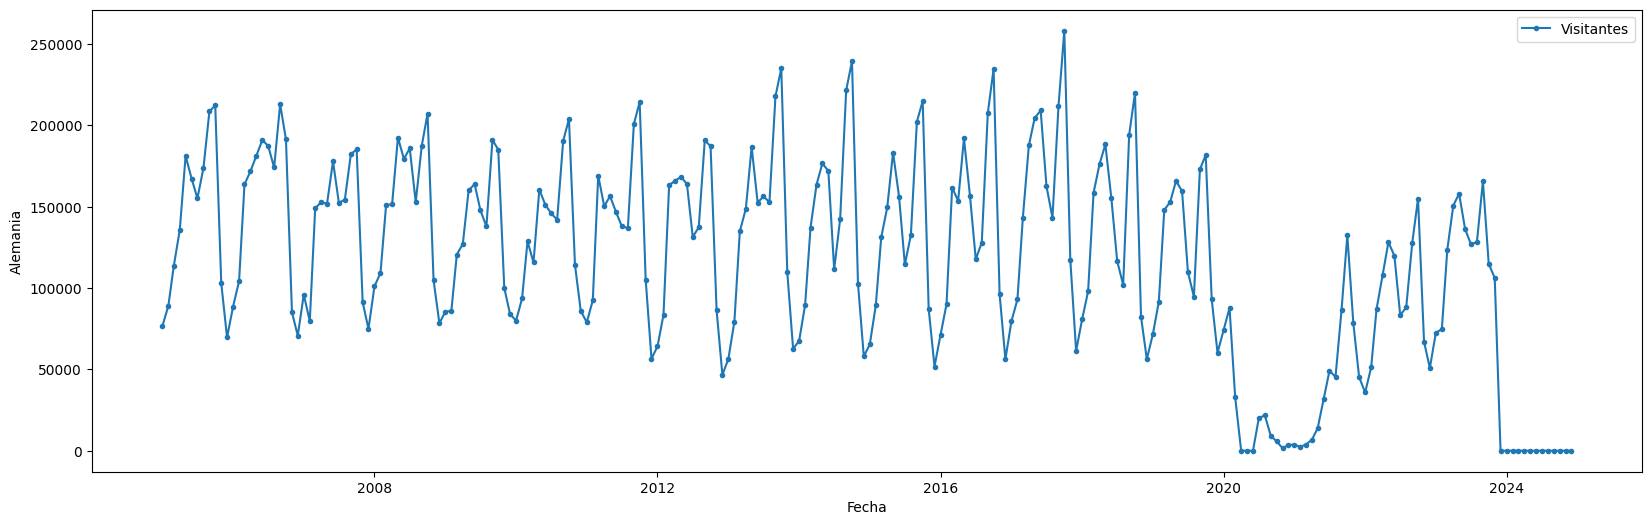

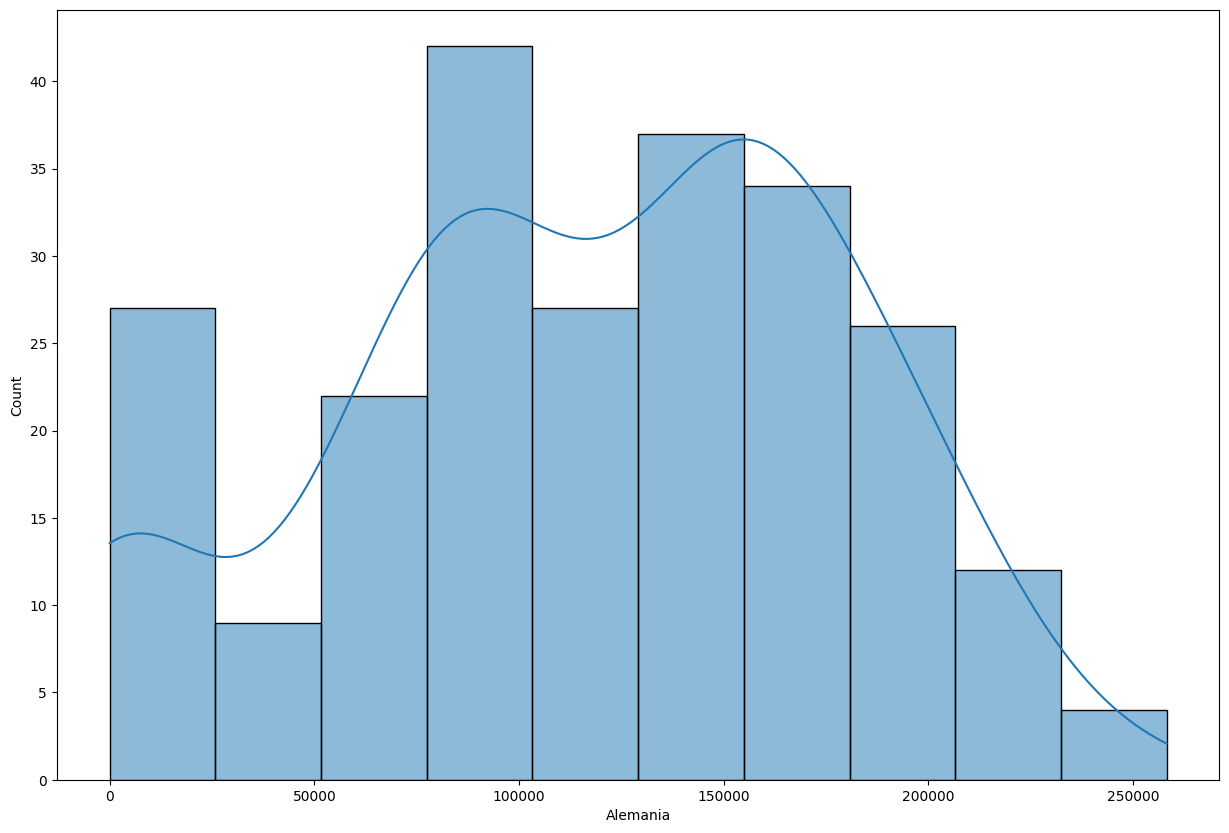

In [3]:
df = pd.read_csv('/home/juancarlos/Desktop/personal/explanable-model-drift/results/preprocessing/tourism_alemania.csv', sep=";", decimal=".", encoding="utf-8")
date_column = 'Fecha'
target_column = 'Alemania'

df[date_column] = pd.to_datetime(df[date_column], format='%Y-%m')
plt.subplots(1, 1, figsize=(20, 6))
sns.lineplot(x=date_column, y=target_column, data=df, label='Visitantes', marker='o', markeredgewidth=0, markersize=4)
plt.show()

plt.subplots(1, 1, figsize=(15, 10))
sns.histplot(df[target_column], kde=True, label='Distribución de Visitantes')
plt.show()

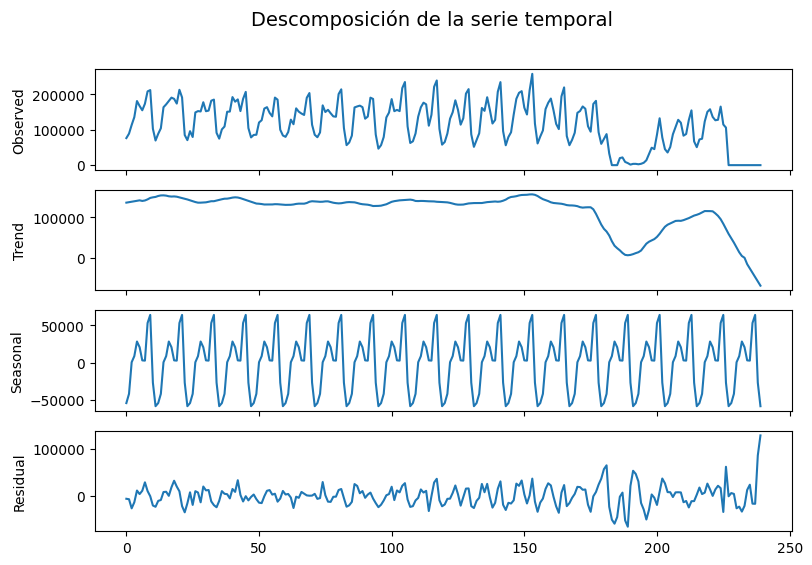

In [4]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)
res_decompose = seasonal_decompose(df[target_column], model='additive', period=12, extrapolate_trend='freq')

res_decompose.observed.plot(ax=axs[0], legend=False)
axs[0].set_ylabel('Observed')
res_decompose.trend.plot(ax=axs[1], legend=False)
axs[1].set_ylabel('Trend')
res_decompose.seasonal.plot(ax=axs[2], legend=False)
axs[2].set_ylabel('Seasonal')
res_decompose.resid.plot(ax=axs[3], legend=False)
axs[3].set_ylabel('Residual')
fig.suptitle('Descomposición de la serie temporal', fontsize=14)
plt.show()

## Global variables and feature lagging


In [5]:
cut_date = '2014-01'
df.drop(columns=['Mortalidad'], inplace=True)
# df_timed = df.set_index('Fecha')
df_train = df.loc[df["Fecha"] < cut_date].copy()
df_rest = df.loc[df["Fecha"] >= cut_date].copy()

seasonality = (12, 'ME') # See: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases

In [6]:
from drift_prediction import time_series_transform_df


timeseries_train = time_series_transform_df(df_train, date_column, seasonality)
timeseries_rest = time_series_transform_df(df_rest, date_column, seasonality)
timeseries_df = time_series_transform_df(df, date_column, seasonality)

new_target_column = target_column + '_t-0'

X_train = timeseries_train.drop(columns=[new_target_column])
y_train = timeseries_train[new_target_column]

## Feature selection
Options:
 - Permutation importance (model dependent)
 - mutual info (model independent)
 - correlation matrix (model independent)
 - Explicability (model dependent)

Finally opted for removing correlation redundant features and using mutual information to select the most important features.

Removed columns: 83
Columns: {'Asientos ofertados_t-5', 'Pib Pc_t-5', 'Pib Pc_t-3', 'Desempleo Armonizado_t-3', 'Alemania_t-12', 'Pib Pc_t-8', 'Indice del consumidor_t-1', 'IPC España Armonizado_t-6', 'IPC España Armonizado_t-9', 'IPC Armonizado_t-5', 'IPC Armonizado_t-7', 'Desempleo Armonizado_t-11', 'Llegadas a AGP Alemania_t-3', 'Indice del consumidor_t-3', 'IPC España Armonizado_t-5', 'Llegadas a AGP Alemania_t-8', 'Desempleo Armonizado_t-5', 'IPC España Armonizado_t-4', 'Alemania_t-11', 'Pib Pc_t-11', 'IPC España Armonizado_t-1', 'IPC España Armonizado_t-12', 'Desempleo Armonizado_t-9', 'Asientos ofertados_t-3', 'IPC Armonizado_t-0', 'Pib Pc_t-6', 'Alemania_t-2', 'IPC Armonizado_t-11', 'Indice del consumidor_t-10', 'Alemania_t-6', 'IPC Armonizado_t-1', 'Llegadas a AGP Alemania_t-12', 'Indice del consumidor_t-4', 'Asientos ofertados_t-11', 'Asientos ofertados_t-9', 'IPC Armonizado_t-10', 'Asientos ofertados_t-2', 'Alemania_t-7', 'Desempleo Armonizado_t-10', 'Indice del consumidor_t

(96, 20)

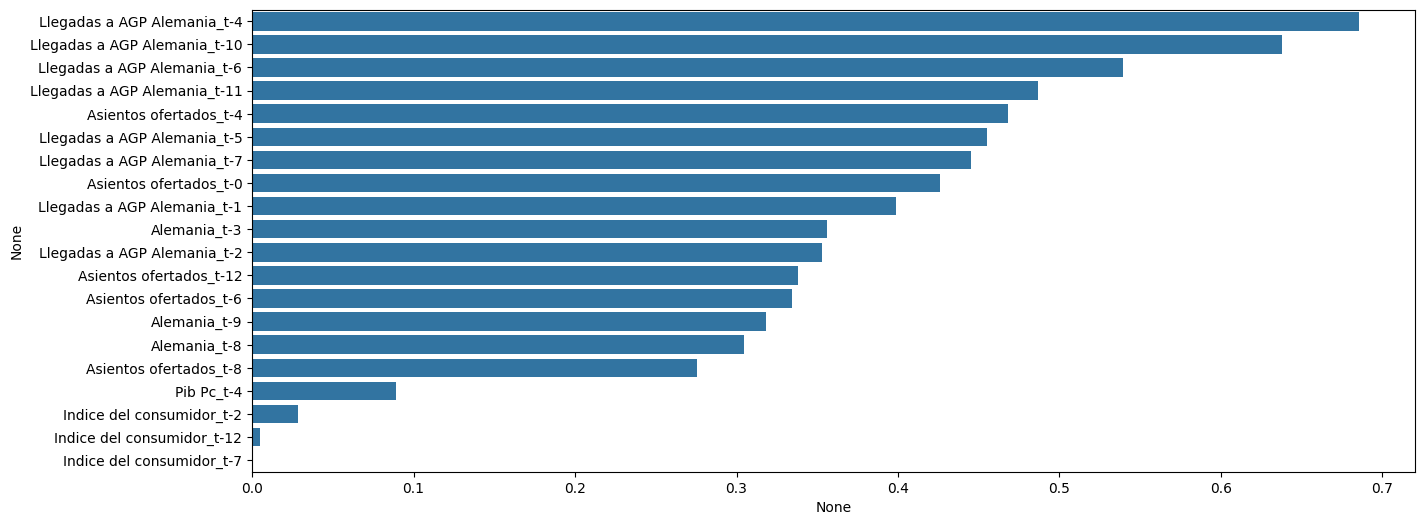

In [7]:
from sklearn.feature_selection import mutual_info_regression 

# Multicorrelation analysis and redundancy removal
corr_matrix = timeseries_train.corr('pearson')
max_corr_threshold = 0.8

corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
high_corr_pairs = corr_pairs[(corr_pairs < 1) & (corr_pairs > max_corr_threshold)]

to_drop = set()
for pair in high_corr_pairs.index:
    if pair[0] not in to_drop and pair[1] not in to_drop:
        pair_0_corr_target = corr_matrix[new_target_column].abs()[pair[0]]
        pair_1_corr_target = corr_matrix[new_target_column].abs()[pair[1]]
        if pair_0_corr_target >= pair_1_corr_target:
            to_drop.add(pair[1])
        else:
            to_drop.add(pair[0])
filtered_data = X_train.drop(columns=to_drop)
print(f"Removed columns: {len(to_drop)}")
print(f"Columns: {to_drop}")

# Mutual information analysis for feature selection
mi = mutual_info_regression(filtered_data, y_train)
mi = pd.Series(mi, index=filtered_data.columns).abs().sort_values(ascending=False)
X_train_mi = X_train[mi.index[:20]]

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.barplot(x=mi[:20], y=mi[:20].index, ax=ax)
fig.show()

X_train_mi.shape

In [8]:
# from xgboost import XGBRegressor

# model = XGBRegressor(n_estimators=100)
# model.fit(filtered_data, y_train)
# ft_importance = model.feature_importances_
# ft_importance = pd.Series(ft_importance, index=filtered_data.columns).sort_values(ascending=False)

# sns.barplot(x=ft_importance[:20], y=ft_importance[:20].index)

# X_train_ft = X_train[ft_importance.index[:20]]


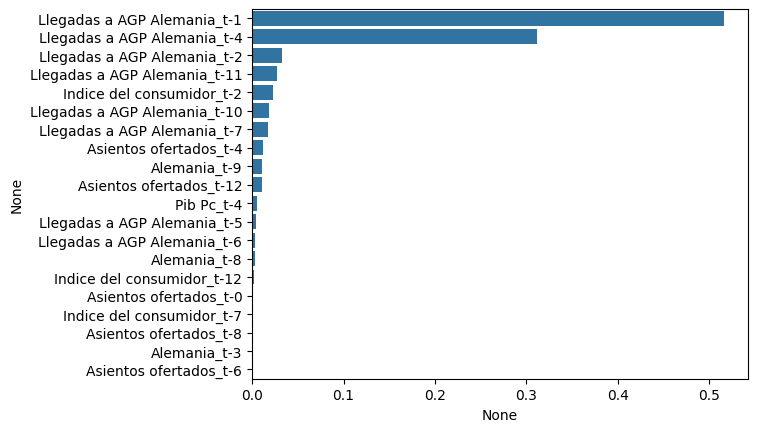

In [9]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# model = RandomForestRegressor()
model = XGBRegressor()
model.fit(filtered_data, y_train)
ft_importance = model.feature_importances_
ft_importance = pd.Series(ft_importance, index=filtered_data.columns).sort_values(ascending=False)

sns.barplot(x=ft_importance[:20], y=ft_importance[:20].index)
X_train_ft = X_train[ft_importance.index[:20]]


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error, accuracy_score, roc_auc_score, f1_score

timeseries_split = TimeSeriesSplit(n_splits=5, test_size=seasonality[0])

# model = RandomForestRegressor()
# GS = GridSearchCV(
#     model,
#     param_grid={
#         'n_estimators': [50, 100, 250, 500, 1000],
#         'max_depth': [1, 2, 5, 10, 20, 25],
#         'max_features': ['auto', 'sqrt', 'log2'],
#     },
#     cv=timeseries_split,
#     n_jobs=-1,
#     scoring=["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], # Scoring must be a str from one of the following: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
#     refit="r2",
# )

# model = GradientBoostingRegressor()
# GS = GridSearchCV(model, param_grid={'n_estimators': [50, 100, 250, 500, 1000], 'max_depth': [2, 5, 10, 20, 25, 50]}, cv=timeseries_split, n_jobs=-1)

# model = LinearRegression()
# GS = GridSearchCV(model, param_grid={}, cv=timeseries_split, n_jobs=-1)

# model = MLPRegressor()
# GS = GridSearchCV(model, param_grid={
#     'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100), (100, 100, 100, 100)],
#     'alpha': [0.0001, 0.001, 0.01, 0.1],
#     'learning_rate': ['constant', 'invscaling', 'adaptive'],
#     'max_iter': [200, 400, 600, 800, 1000]

# }, cv=timeseries_split, n_jobs=-1)

# model = ElasticNet()
# GS = GridSearchCV(model, param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9], 'max_iter': [100, 1000, 10000, 100000, 1000000]}, cv=timeseries_split, n_jobs=-1)

# model = BayesianRidge()
# GS = GridSearchCV(model, param_grid={'n_iter': [100, 1000, 10000, 100000, 1000000]}, cv=timeseries_split, n_jobs=-1)

model = XGBRegressor()
GS = GridSearchCV(
    model,
    param_grid={
        'n_estimators': [50, 100, 250, 500, 1000],
        'max_depth': [2, 5, 10, 20, 25, 50],
        'learning_rate': [0.01, 0.1, 0.3, 0.5],
        'gamma': [0.0, 0.1, 0.2, 0.3],
    },
    cv=timeseries_split,
    n_jobs=-1,
    scoring=["r2", "neg_root_mean_squared_error", "neg_mean_absolute_error"], # Scoring must be a str from one of the following: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
    refit="r2",
)

GS.fit(X_train_ft, y_train)
params = GS.best_params_
print(GS.best_score_)
print(params)

0.6005047007052375
{'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 500}


In [11]:
for train_idx, test_idx in timeseries_split.split(X_train_ft):
    X_train_cv, X_test_cv = X_train_ft.iloc[train_idx], X_train_ft.iloc[test_idx]
    y_train_cv, y_test_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
    print("Train:", X_train_cv.index.min(), X_train_cv.index.max(), "- Test:", X_test_cv.index.min(), X_test_cv.index.max())
    

Train: 2006-01-31 00:00:00 2008-12-31 00:00:00 - Test: 2009-01-31 00:00:00 2009-12-31 00:00:00
Train: 2006-01-31 00:00:00 2009-12-31 00:00:00 - Test: 2010-01-31 00:00:00 2010-12-31 00:00:00
Train: 2006-01-31 00:00:00 2010-12-31 00:00:00 - Test: 2011-01-31 00:00:00 2011-12-31 00:00:00
Train: 2006-01-31 00:00:00 2011-12-31 00:00:00 - Test: 2012-01-31 00:00:00 2012-12-31 00:00:00
Train: 2006-01-31 00:00:00 2012-12-31 00:00:00 - Test: 2013-01-31 00:00:00 2013-12-31 00:00:00


## Prediction

Prediction pipeline

In [12]:
import shap.maskers
from sklearn.base import is_regressor, is_classifier

def time_series_predict(
    model: object,
    prev_shap_values: list,
    data: pd.DataFrame,
    target: pd.Series,
    explainer: shap.Explainer,
    distance_metric="euclidean",
):
    def __euclidean_distance(X, Y):
        return np.sqrt(np.sum(np.square(X - Y)))

    def __manhattan_distance(X, Y):
        return np.sum(np.abs(X - Y))

    pred = model.predict(data)

    measure = {}
    if is_regressor(model):
        measure = {
            "R2": r2_score(target, pred),
            "MAE": mean_absolute_error(target, pred),
            "RMSE": root_mean_squared_error(target, pred),
        }
        print(measure)
    elif is_classifier(model):
        measure = {
            "ACC": accuracy_score(target, pred),
            "F1": f1_score(target, pred),
            "ROC_AUC": roc_auc_score(target, pred)
        }
        print(measure)
    else:
        raise ValueError("Model not supported")
    
    test_shap_values = explainer.shap_values(data)
    prev_explain_means = np.mean(prev_shap_values, axis=0)
    test_explain_means = np.mean(test_shap_values, axis=0)

    # shap.bar_plot(prev_explain_means, data.columns, max_display=20)
    # shap.bar_plot(test_explain_means, data.columns, max_display=20)

    # Normalize shap values
    prev_explain_means = (prev_explain_means - np.mean(prev_explain_means)) / np.std(
        prev_explain_means
    )
    test_explain_means = (test_explain_means - np.mean(test_explain_means)) / np.std(
        test_explain_means
    )

    # Calculate distance between previous and test data
    distances = []
    match distance_metric:
        case "euclidean":
            distances = [
                __euclidean_distance(prev_feat, test_feat)
                for prev_feat, test_feat in zip(prev_explain_means, test_explain_means)
            ]
        case "manhattan":
            distances = [
                __manhattan_distance(prev_feat, test_feat)
                for prev_feat, test_feat in zip(prev_explain_means, test_explain_means)
            ]
        case _:
            raise ValueError(
                "Invalid distance metric. Choose from 'euclidean' or 'manhattan'."
            )

    xai_results = pd.DataFrame(
        {
            "Previous explained importance": prev_explain_means,
            "Test explained importance": test_explain_means,
            "Distance": distances,
        },
        index=data.columns,
    )
    return pred, measure, xai_results

def prediction(
        ai,
        train_data,
        train_target,
        test_val_data,
        total_data,
        target_col,
        distance_metric="euclidean",
):
    ai.fit(train_data, train_target)
    # explainer = shap.Explainer(ai, masker=shap.maskers.Independent(data=train_data))
    explainer = shap.TreeExplainer(ai, train_data)
    train_shap = explainer.shap_values(train_data.head(24))

    preds = {}
    xais = {}
    measures = {
        'train': {
            'R2': r2_score(train_target, ai.predict(train_data)),
            'MAE': mean_absolute_error(train_target, ai.predict(train_data)),
            'RMSE': root_mean_squared_error(train_target, ai.predict(train_data))
        }
    }

    for year in test_val_data.index.year.unique():
        print(year)
        test_year = test_val_data[test_val_data.index.year == year]

        X_test = test_year.drop(columns=[target_col])
        y_test = test_year[target_col]

        preds[year], measures[str(year)], xais[year] = time_series_predict(
            model=ai,
            prev_shap_values=train_shap,
            data=X_test,
            target=y_test,
            explainer=explainer,
            distance_metric=distance_metric
        )
        print("-----")

    fig = plt.figure(figsize=(25, 10))
    ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
    sns.lineplot(x=total_data.index, y=total_data[target_col], label='Real', linewidth=3, alpha=0.5, color='gray', ax=ax1)
    for year in preds.keys():
        sns.lineplot(x=total_data[total_data.index.year == year].index, y=preds[year], label=f'Predicción {year}', marker='o', markeredgewidth=0, markersize=4, ax=ax1)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.125, 1))
    ax1.set_title('Predicción de la serie temporal', fontsize=14)

    ax2_1 = plt.subplot2grid((3, 3), (1, 0))
    ax2_2 = plt.subplot2grid((3, 3), (1, 1))
    ax2_3 = plt.subplot2grid((3, 3), (1, 2))
    
    measures_df = pd.DataFrame(measures).T

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_1 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[0]]):
        ax2_1.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_1.set_title(measures_df.columns[0])

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_2 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[1]]):
        ax2_2.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_2.set_title(measures_df.columns[1])

    sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_3 , linewidth=2)
    for i, txt in enumerate(measures_df[measures_df.columns[2]]):
        ax2_3.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
    ax2_3.set_title(measures_df.columns[2])

    fig.tight_layout(pad=1.0)
    fig.show()

    fig, ax = plt.subplots(1, 1, figsize=(25, 10))

    xais_df = pd.concat(xais).reset_index().rename(columns={'level_0': 'Year', 'level_1': 'Feature'})   
    sns.lineplot(x=xais_df['Year'], y=xais_df['Distance'], hue=xais_df['Feature'], ax=ax, linewidth=2, palette='tab20', marker='o', markeredgewidth=0, markersize=4)
    ax.grid()
    ax.set_title('Importancia de las variables explicativas')
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=7)

    fig.show()

    return model, explainer, preds, measures, xais


metrics drift pipeline

In [13]:
def calculate_z_score(val, batch):
        if batch == [] or np.std(batch) == 0:
            return 0
        return (val - np.median(batch)) / np.std(batch)

def calculate_measures_drift(
    measures: dict,
    train_measure: dict,
    drift_threshold: float
):
    drift = {}
    measures_variance = {}

    batch = {
        'R2': [],
        'MAE': [],
        'RMSE': []
    }
    for key, measure in measures.items():
        r2_variance = ((measure['R2'] - train_measure['R2'])/train_measure['R2']) * 100 if measure['R2'] != np.nan else 0
        mae_variance = ((measure['MAE'] - train_measure['MAE'])/train_measure['MAE']) * 100
        rmse_variance = ((measure['RMSE'] - train_measure['RMSE'])/train_measure['RMSE']) * 100

        measures_variance[key] = {
            'R2': r2_variance,
            'MAE': mae_variance,
            'RMSE': rmse_variance
        }

        r2_z_score = calculate_z_score(r2_variance, batch['R2'])
        mae_z_score = calculate_z_score(mae_variance, batch['MAE'])
        rmse_z_score = calculate_z_score(rmse_variance, batch['RMSE'])

        concept_drift_score = np.sqrt(r2_z_score**2 + mae_z_score**2 + rmse_z_score**2)
        drift[key] = concept_drift_score

        # Usamos el drift threshold para detectar el cambio de concepto y si no se produce añadimos los valores a la lista de varianzas
        if concept_drift_score > drift_threshold:
            print(f"Concept drift detected at year {key}")
        else:
            batch['R2'].append(r2_variance)
            batch['MAE'].append(mae_variance)
            batch['RMSE'].append(rmse_variance)

    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    sns.lineplot(drift.values(), marker='o', markeredgewidth=0, markersize=4, ax=ax)
    ax.set_xticks(ticks=range(len(drift)), labels=drift.keys())
    ax.hlines(drift_threshold, 0, len(drift), colors='r', linestyles='dashed')
    ax.set_title('Metrics drift detection')
    ax.legend([])
    fig.show

    return drift, measures_variance

### Prediction with complete data

2015
{'R2': 0.595555628422154, 'MAE': 27847.126302083332, 'RMSE': 31990.91932026443}
-----
2016
{'R2': 0.5617205815062962, 'MAE': 26533.828125, 'RMSE': 35227.0977443825}
-----
2017
{'R2': 0.47439028839495945, 'MAE': 25575.929036458332, 'RMSE': 42054.26971008795}
-----
2018
{'R2': -0.1421775627175379, 'MAE': 39994.833984375, 'RMSE': 54258.569146027956}
-----
2019
{'R2': -1.348150039728786, 'MAE': 56975.90234375, 'RMSE': 62648.48491007141}
-----
2020
{'R2': -22.003616968155647, 'MAE': 132456.56640625, 'RMSE': 137009.4797781673}
-----
2021
{'R2': -2.6380399354913564, 'MAE': 62583.697916666664, 'RMSE': 74280.89419293079}
-----
2022
{'R2': -1.2371924150708233, 'MAE': 42310.677083333336, 'RMSE': 52567.06828545071}
-----
2023
{'R2': -1.3505548811027759, 'MAE': 48424.887369791664, 'RMSE': 67443.35976775944}
-----
2024
{'R2': 0.0, 'MAE': 171437.11783854166, 'RMSE': 173217.1883119698}
-----


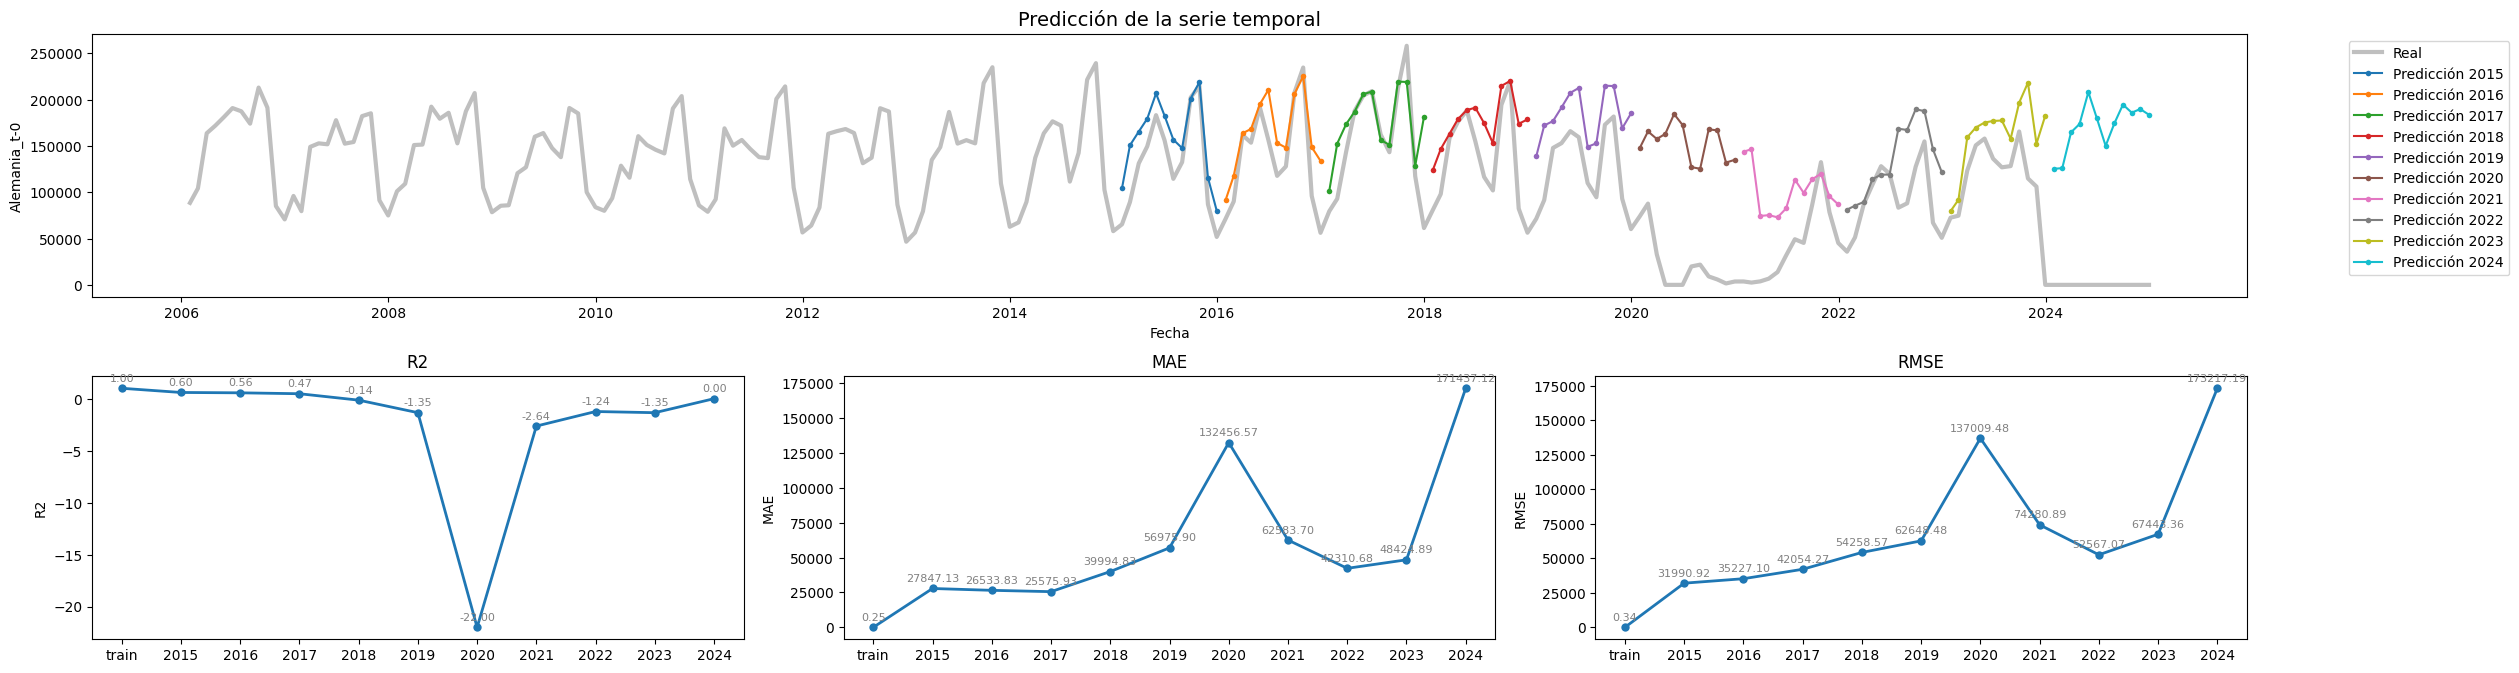

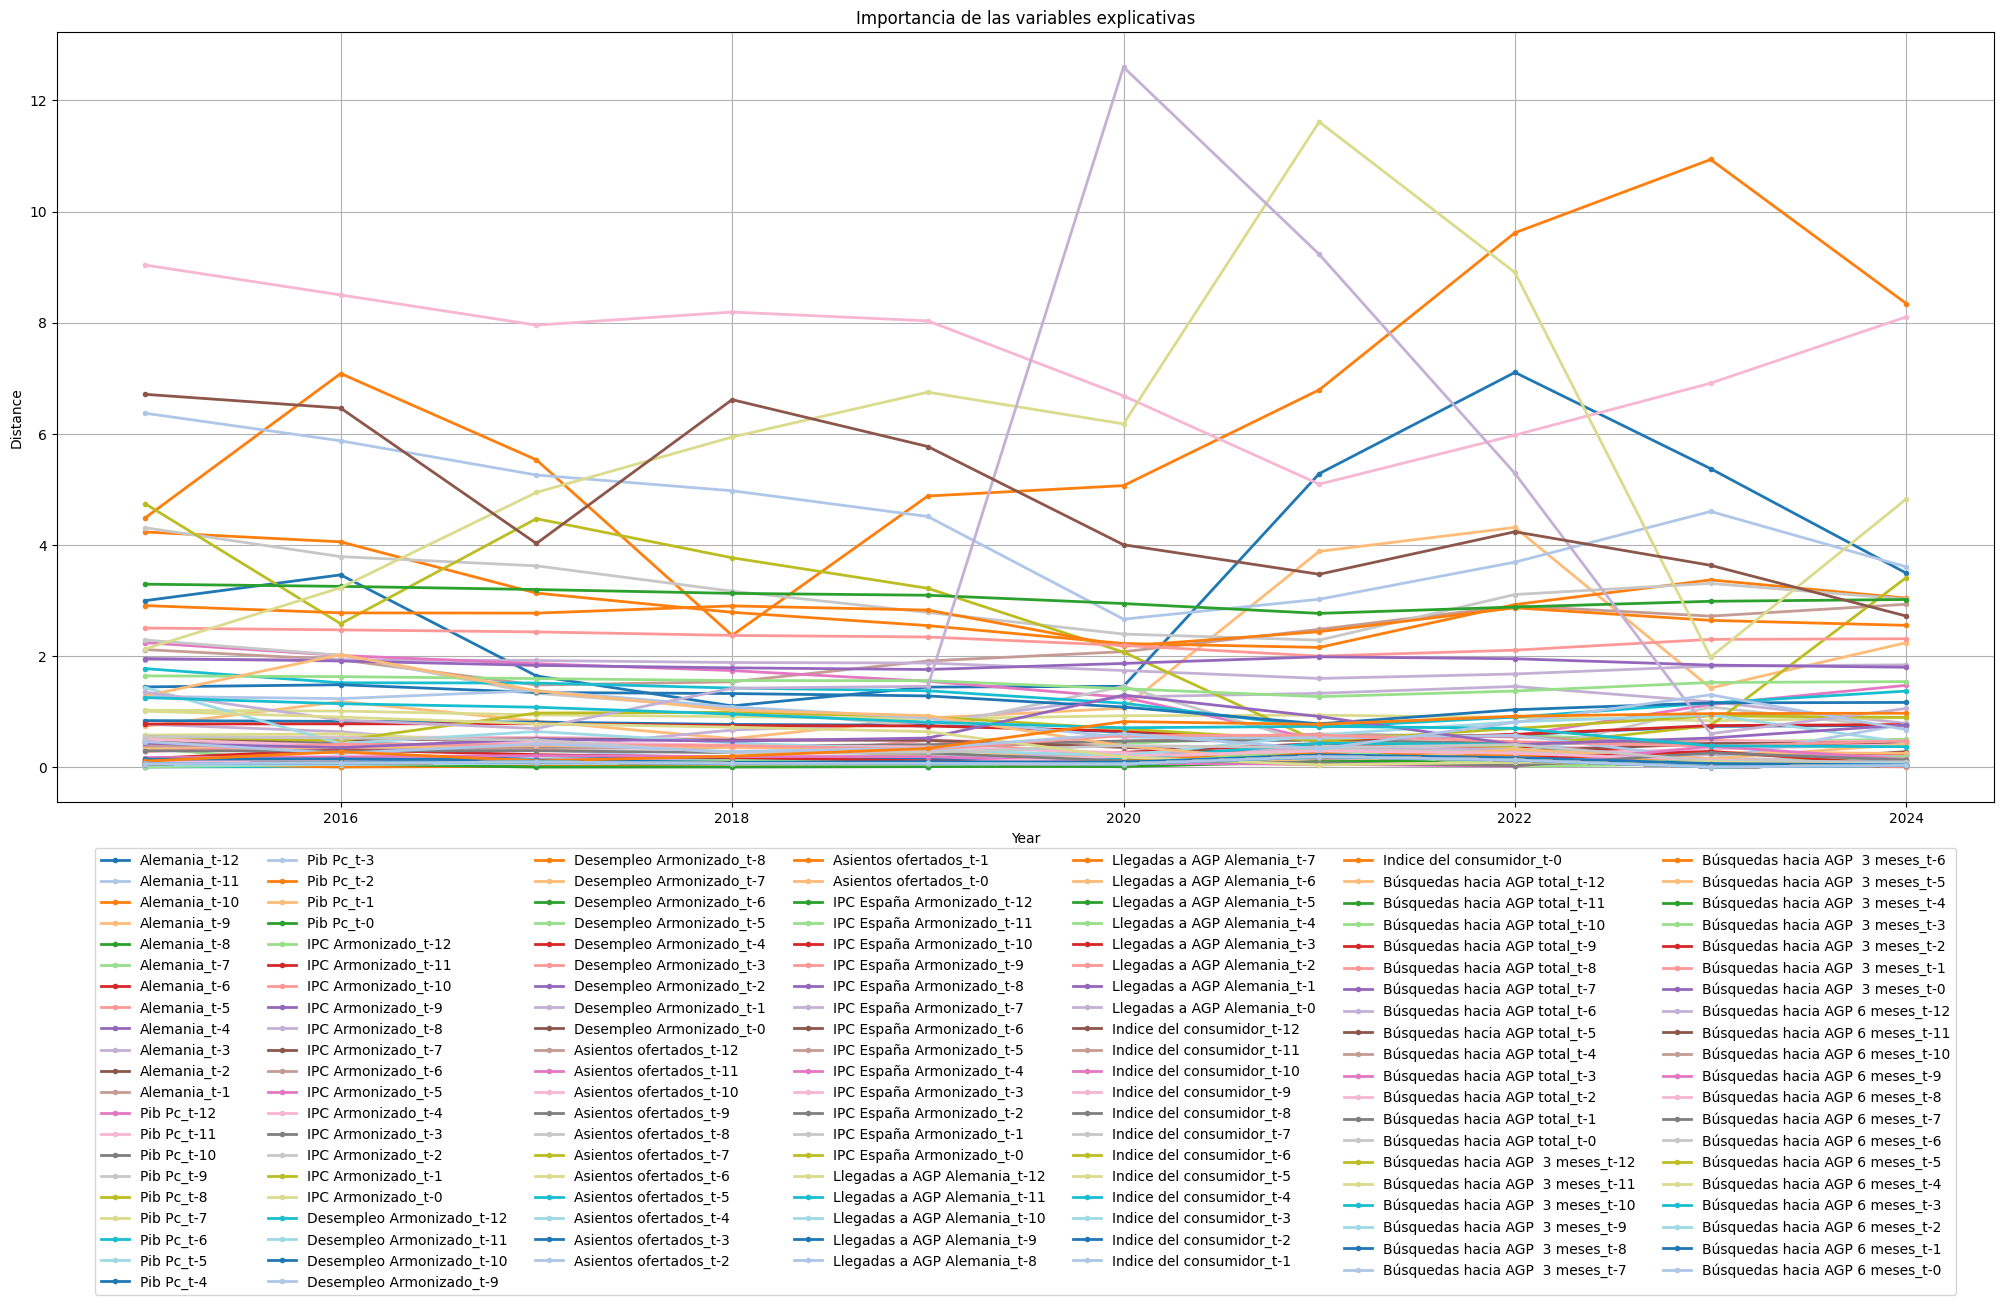

In [14]:
model = XGBRegressor(**params)
model, exp, preds, measures, xais = prediction(
    ai=model,
    train_data=X_train,
    train_target=y_train,
    test_val_data=timeseries_rest,
    total_data=timeseries_df,
    target_col=new_target_column,
    distance_metric='manhattan'
)

Concept drift detected at year 2018
Concept drift detected at year 2019
Concept drift detected at year 2020
Concept drift detected at year 2021
Concept drift detected at year 2022
Concept drift detected at year 2023
Concept drift detected at year 2024
{'2015': 0.0, '2016': 0.0, '2017': 8.441454740209602, '2018': 20.488616292145355, '2019': 50.11712750586443, '2020': 457.0991247181838, '2021': 74.26409892507255, '2022': 39.320907613937486, '2023': 44.89099981043829, '2024': 159.46318063834974}


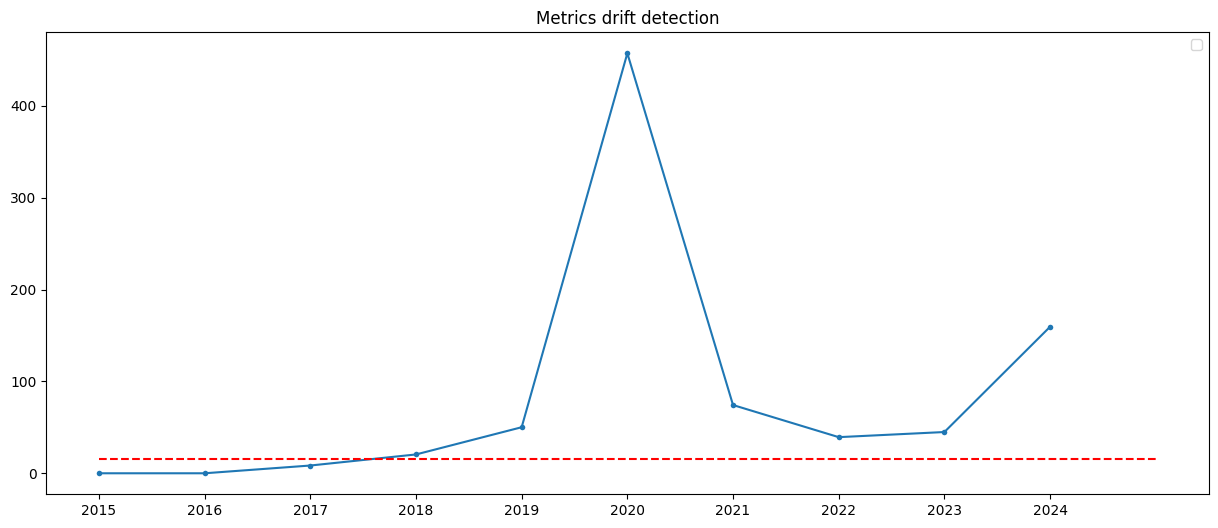

In [15]:
threshold = 15

new_measures = measures.copy()
new_measures.pop(list(measures.keys())[0])
drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)
print(drift)

### Predictions with feature importance data

Prediction with the most important features selected by mutual information and removed the redundant features by correlation matrix.

2015
{'R2': 0.6310455235478569, 'MAE': 22298.350911458332, 'RMSE': 30555.100360085176}
-----
2016
{'R2': 0.6517020292636175, 'MAE': 26998.712239583332, 'RMSE': 31403.40918949096}
-----
2017
{'R2': 0.5910275407965027, 'MAE': 28581.576822916668, 'RMSE': 37095.85938427023}
-----
2018
{'R2': 0.2881531211494398, 'MAE': 35717.901692708336, 'RMSE': 42834.610002984184}
-----
2019
{'R2': -0.10786911498830931, 'MAE': 37587.945963541664, 'RMSE': 43032.03439203617}
-----
2020
{'R2': -15.220230083333309, 'MAE': 108366.412109375, 'RMSE': 115048.52596161436}
-----
2021
{'R2': -8.952707194769454, 'MAE': 118586.58463541667, 'RMSE': 122860.98867765111}
-----
2022
{'R2': -3.4571850843868326, 'MAE': 69935.43359375, 'RMSE': 74198.03805699984}
-----
2023
{'R2': -0.3702836835010406, 'MAE': 38202.880208333336, 'RMSE': 51494.30991347389}
-----
2024
{'R2': 0.0, 'MAE': 158439.42903645834, 'RMSE': 160088.37666210692}
-----


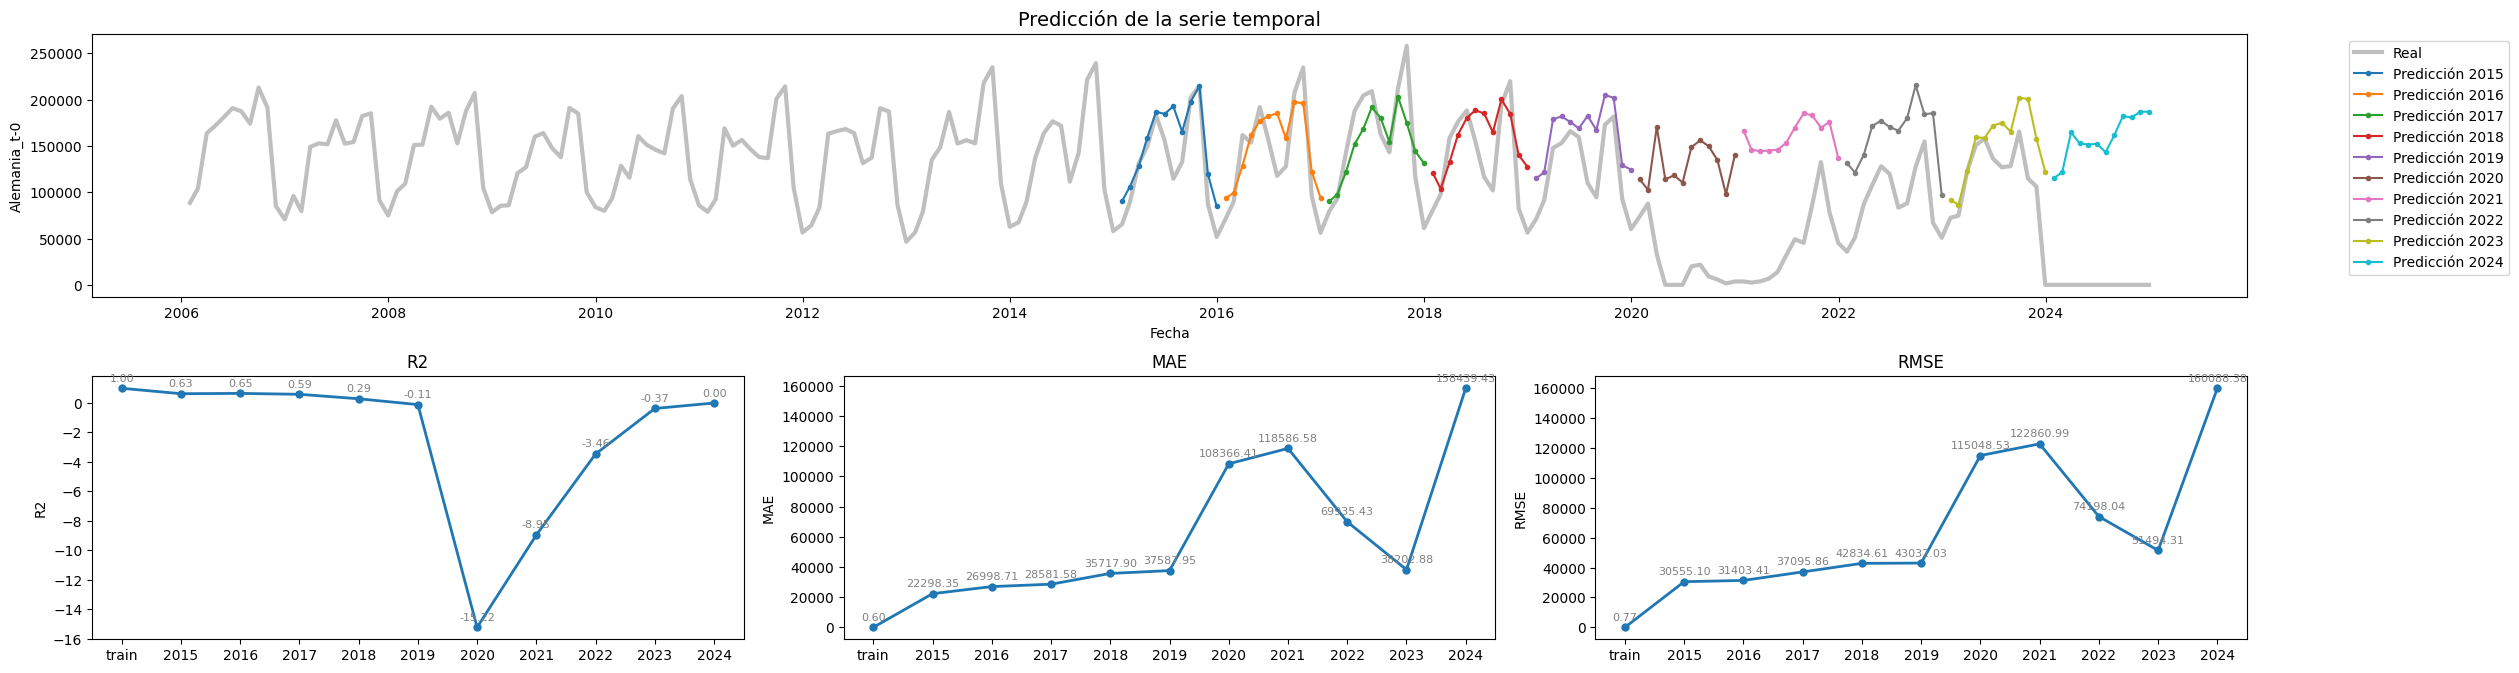

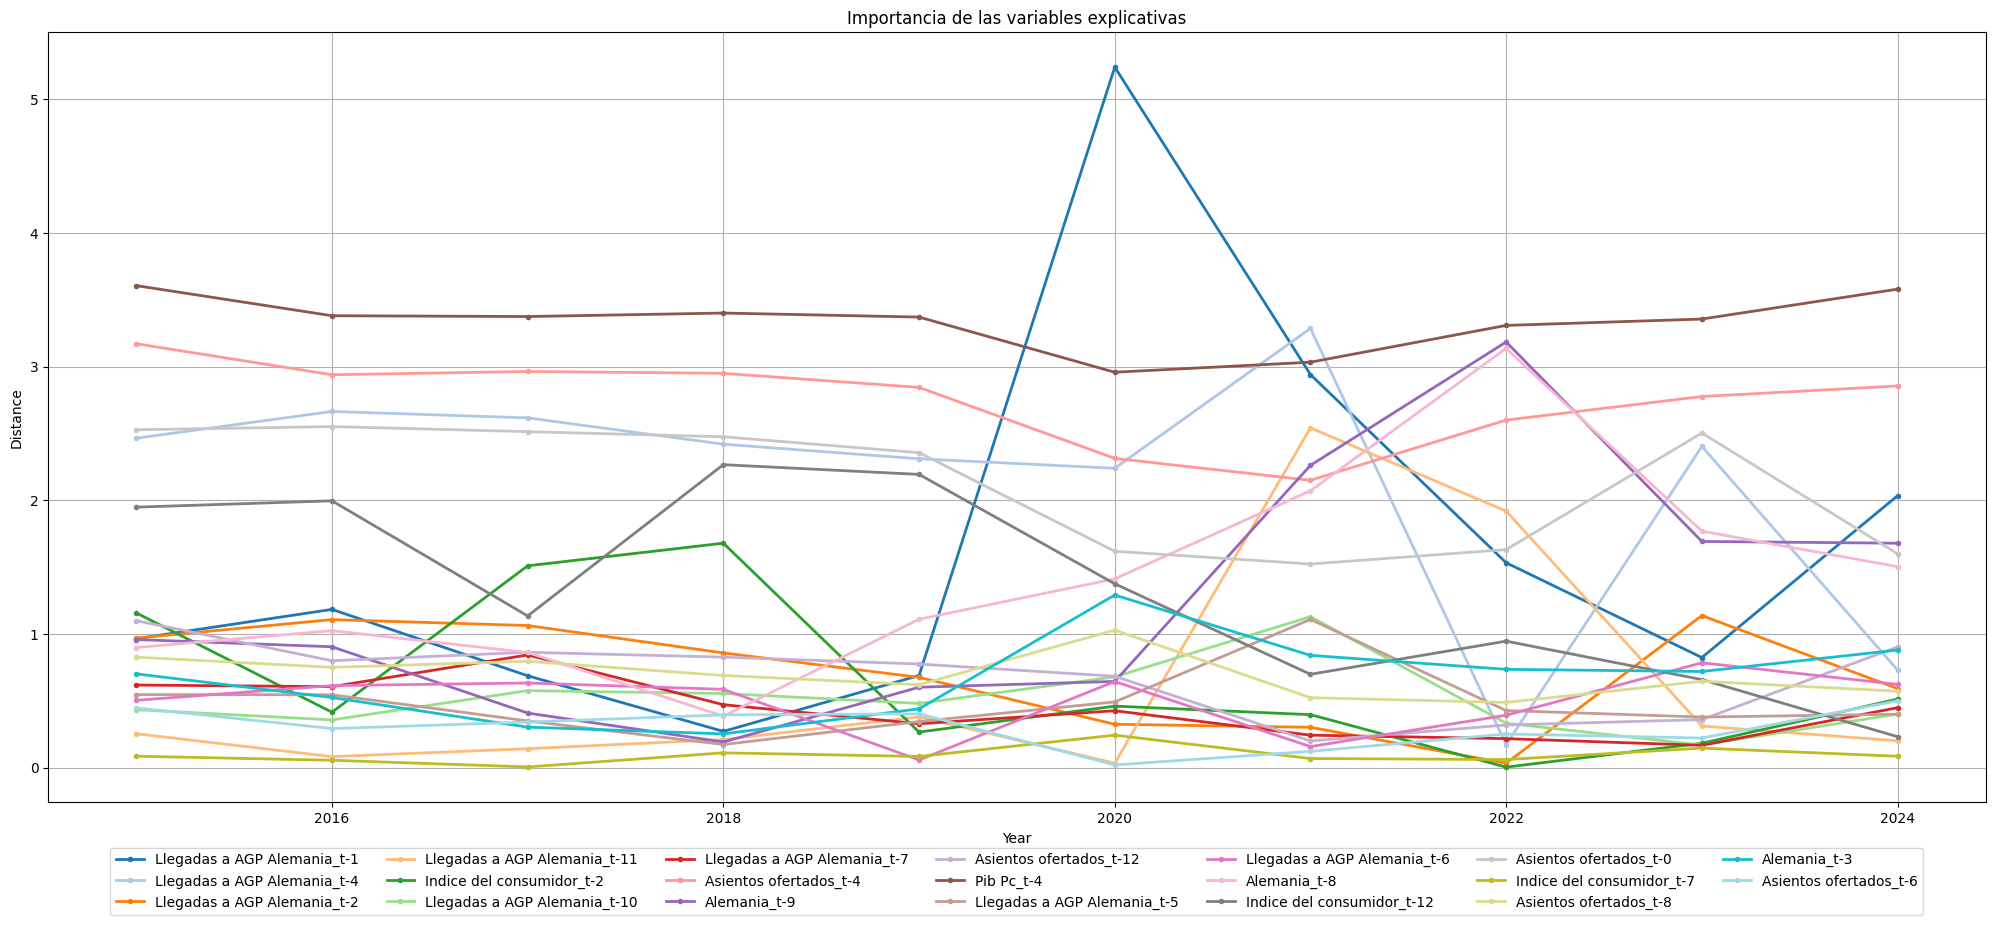

In [35]:
# k=20
# idx = mi.index[:k].to_list()
# train_corr = timeseries_train.copy()[idx]
# idx.append(new_target_column)
# test_val_corr = timeseries_rest.copy()[idx]
# total_corr = timeseries_df.copy()[idx]
# model = XGBRegressor(**params)

# model, exp, preds, measures, xais = prediction(
#     ai=model,
#     train_data=train_corr,
#     train_target=y_train,
#     test_val_data=test_val_corr,
#     total_data=total_corr,
#     target_col=new_target_column
# )

k=20
idx = ft_importance.index[:k].to_list()
train_corr = timeseries_train.copy()[idx]
idx.append(new_target_column)
test_val_corr = timeseries_rest.copy()[idx]
total_corr = timeseries_df.copy()[idx]
model = XGBRegressor(**params)

model, exp, preds, measures, xais = prediction(
    ai=model,
    train_data=train_corr,
    train_target=y_train,
    test_val_data=test_val_corr,
    total_data=total_corr,
    target_col=new_target_column
)

WIP -- DETECTAR DRIFT EN EL MODELO PARA VER SI MEJORA, USAR KS PARA VER SI LA DISTRIBUCION DE LAS EXPLICACIONES CAMBIA 

        pvalue  statistic  distance
2015  0.081058       0.40  1.209112
2016  0.999992       0.10  1.139781
2017  0.999992       0.10  1.099329
2018  0.831970       0.20  1.058436
2019  0.983137       0.15  1.016645
2020  0.983137       0.15  1.206533
2021  0.174533       0.35  1.279821
2022  0.831970       0.20  1.084635
2023  0.081058       0.40  1.060355


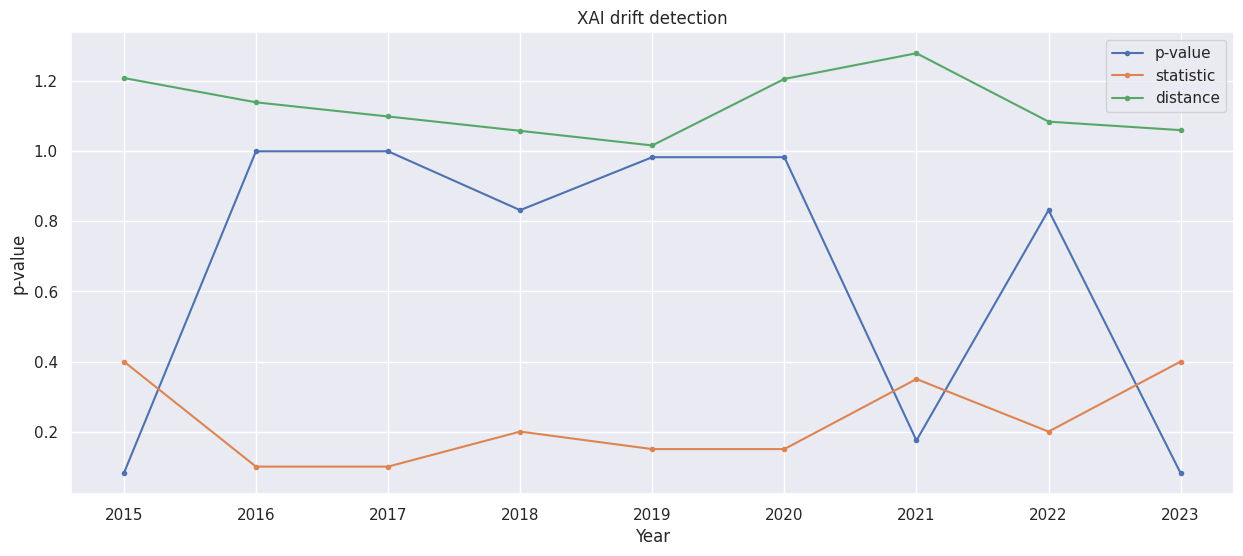

In [97]:
from scipy.stats import ks_2samp

xais_df = pd.concat(xais).reset_index().rename(columns={'level_0': 'Year', 'level_1': 'Feature'})
drift_threshold = 0.15

drift = {}
years = xais_df['Year'].unique()
year1_data = xais_df[xais_df['Year'] == years[0]]

for year in years[1:]:
    year_data = xais_df[xais_df['Year'] == year]
    # ks = ks_2samp(year_data['Previous explained importance'], year_data['Test explained importance'])
    ks= ks_2samp(year1_data['Test explained importance'], year_data['Test explained importance'])
    drift[year] = {}
    drift[year]['pvalue'] = ks.pvalue
    drift[year]['statistic'] = ks.statistic
    drift[year]['distance'] = year_data['Distance'].mean()

drift = pd.DataFrame(drift).T
print(drift)
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
sns.set_theme(style='darkgrid')
sns.lineplot(x=drift.index, y=drift['pvalue'], marker='o', markeredgewidth=0, markersize=4, ax=ax, label='p-value')
sns.lineplot(x=drift.index, y=drift['statistic'], marker='o', markeredgewidth=0, markersize=4, ax=ax, label='statistic')
sns.lineplot(x=drift.index, y=drift['distance'], marker='o', markeredgewidth=0, markersize=4, ax=ax, label='distance')


# for key, value in drift.items():
#     ax.text(key+0.05, value, f'{value:.2f}', ha='left', va='top', fontsize=8)
ax.set_ylabel('p-value')
ax.set_xlabel('Year')
# ax.hlines(drift_threshold, 0, len(drift), colors='r', linestyles='dashed')
ax.set_title('XAI drift detection')
fig.show()

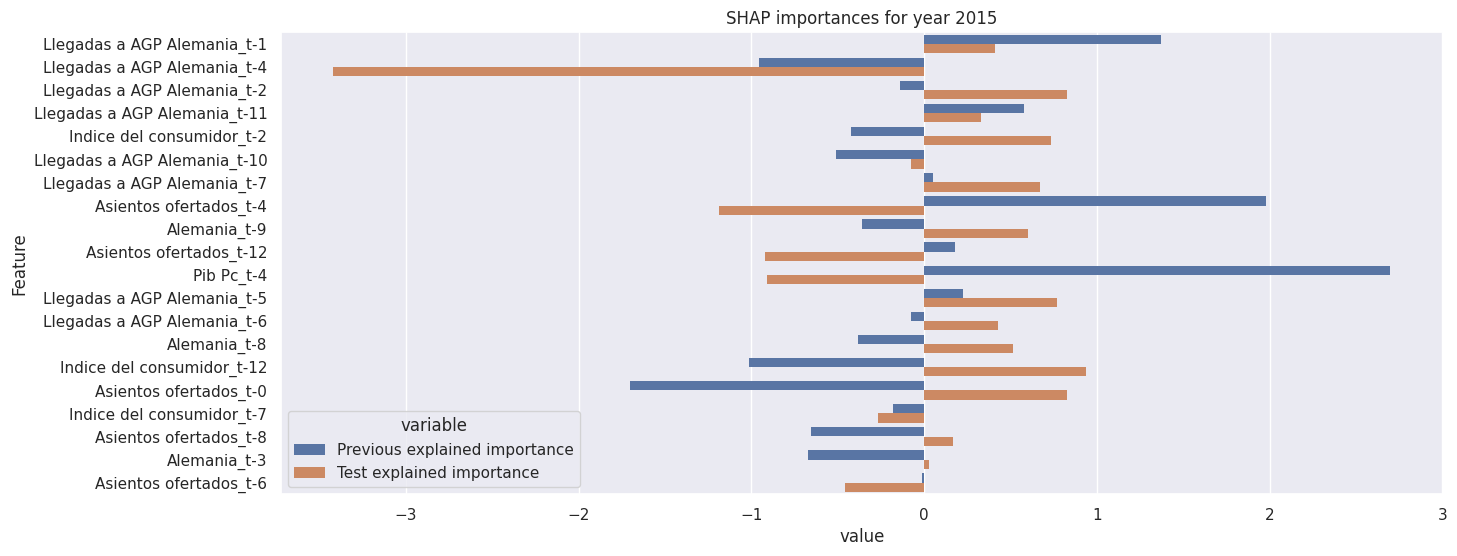

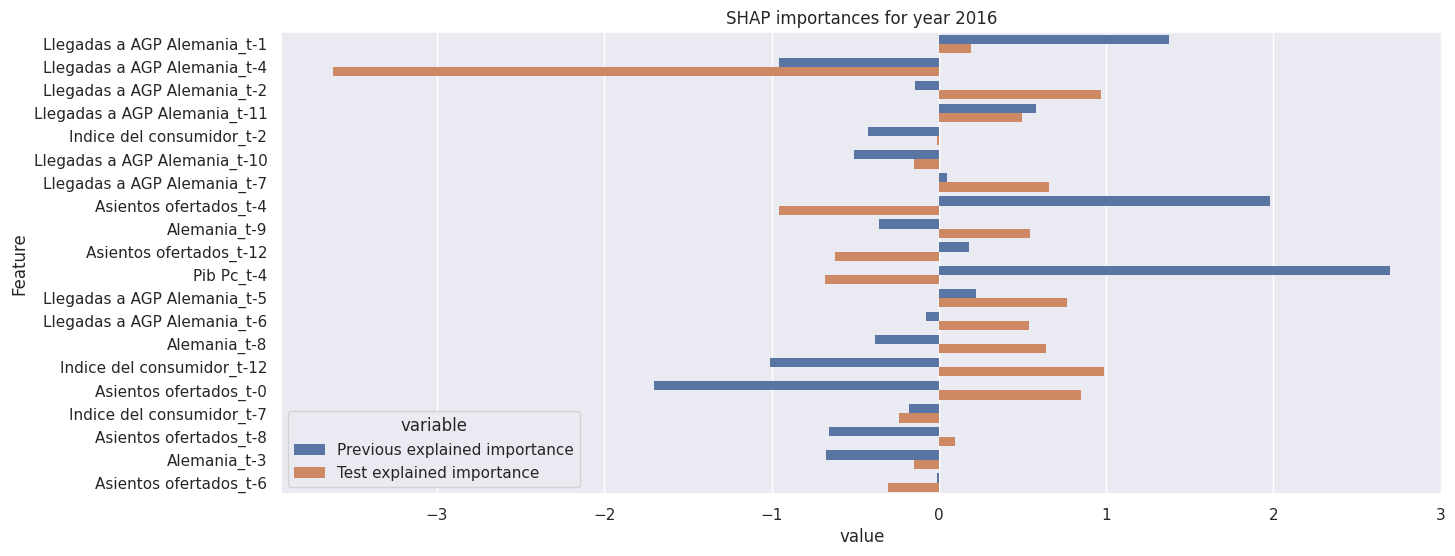

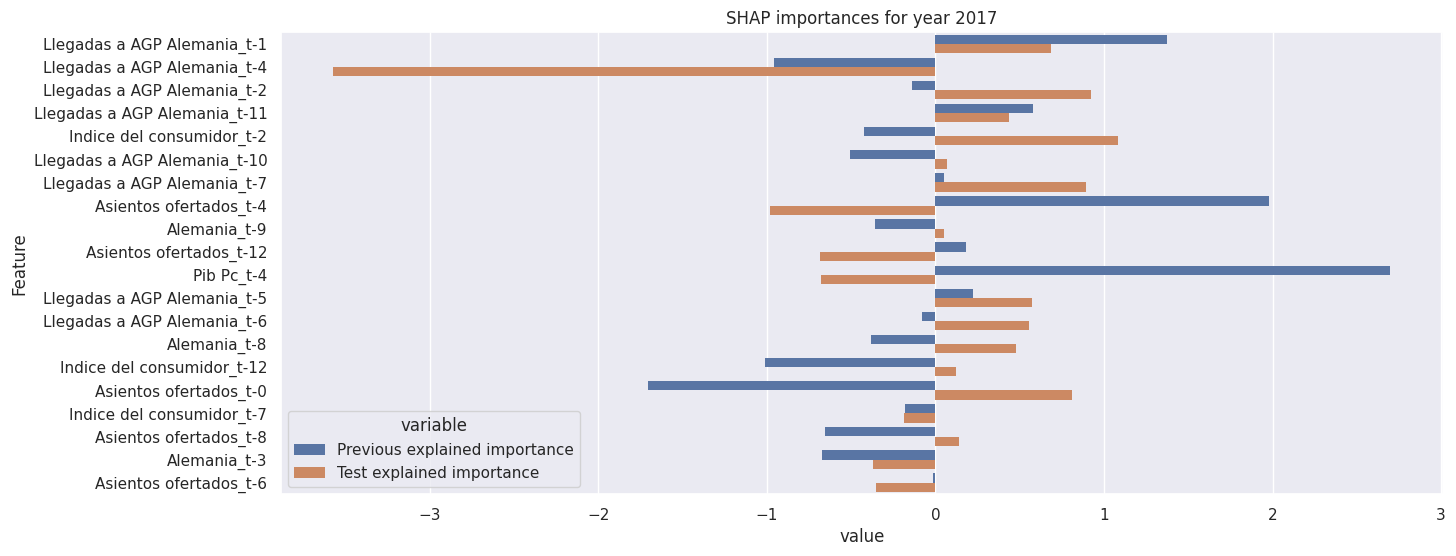

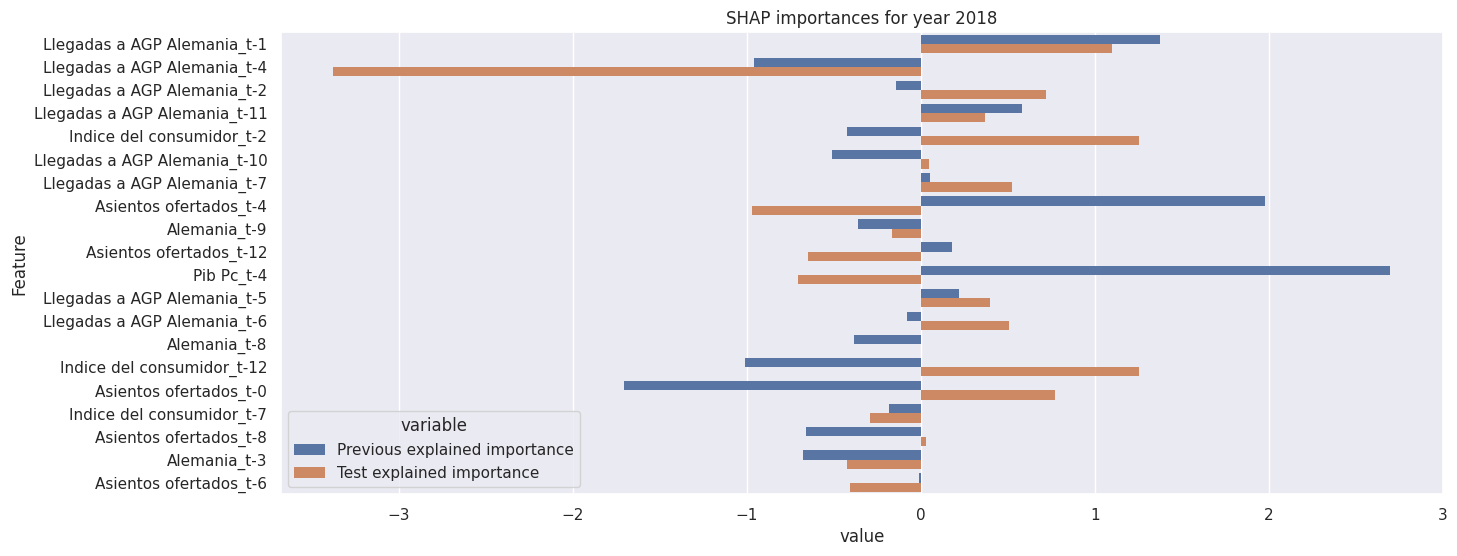

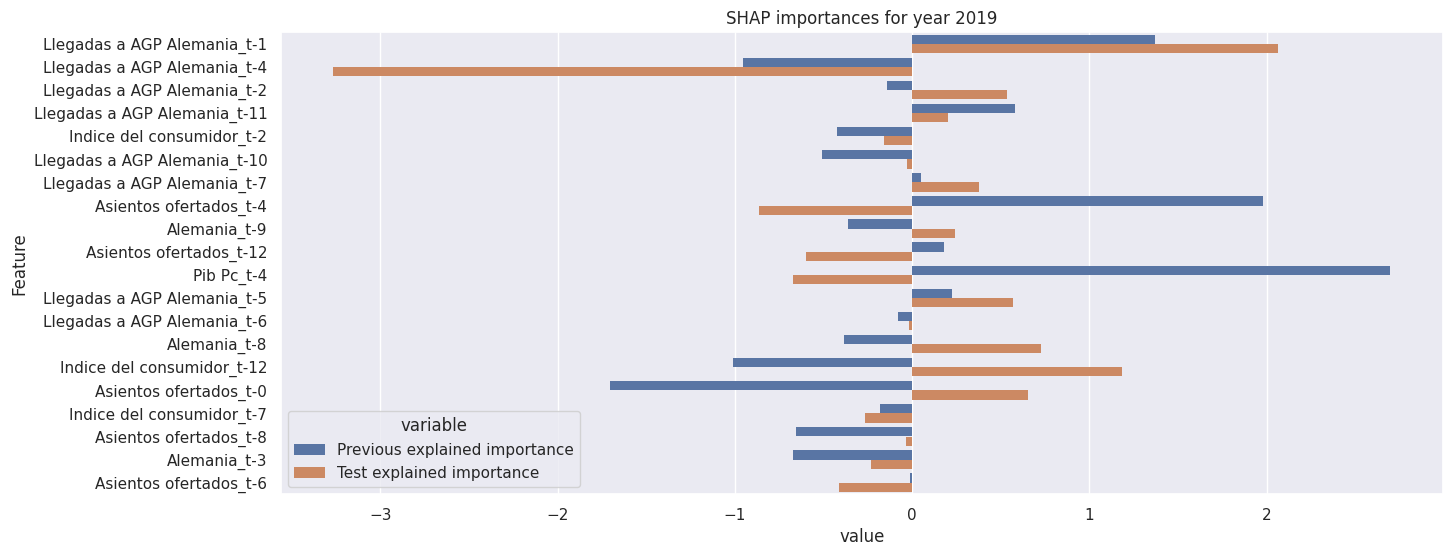

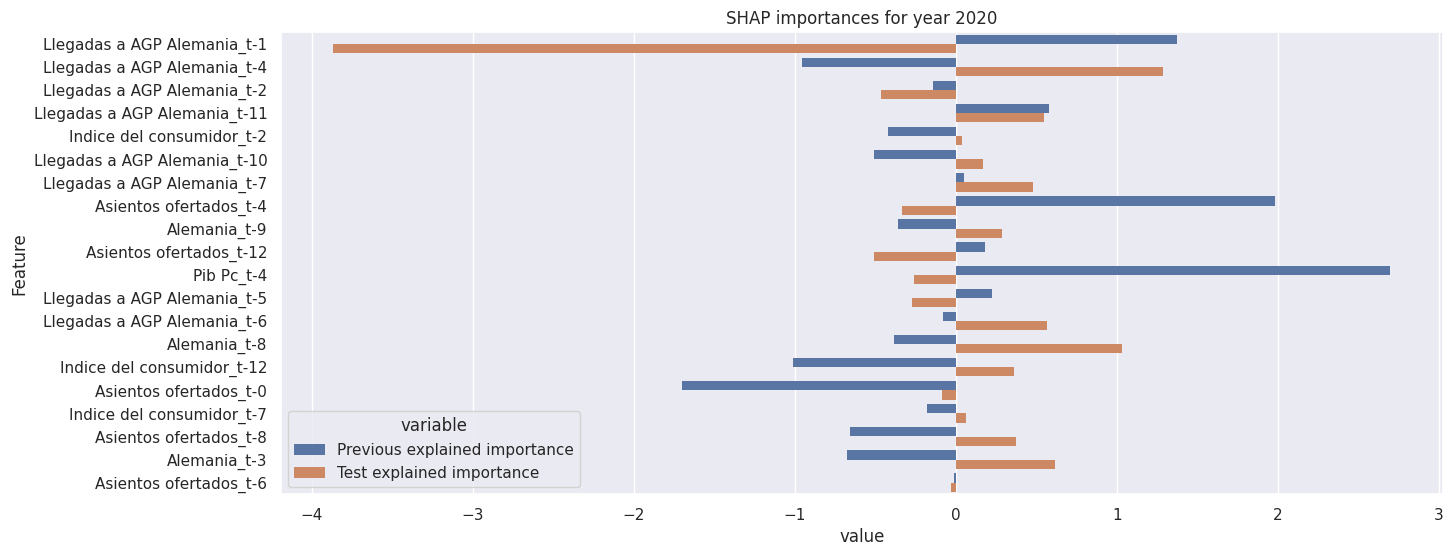

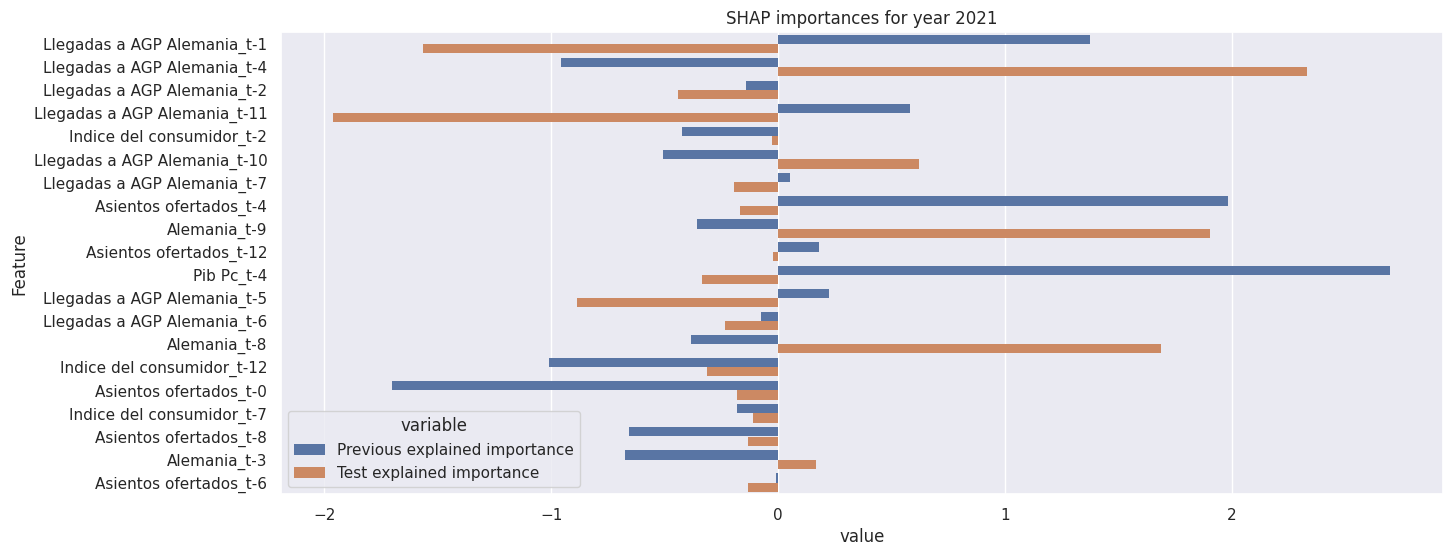

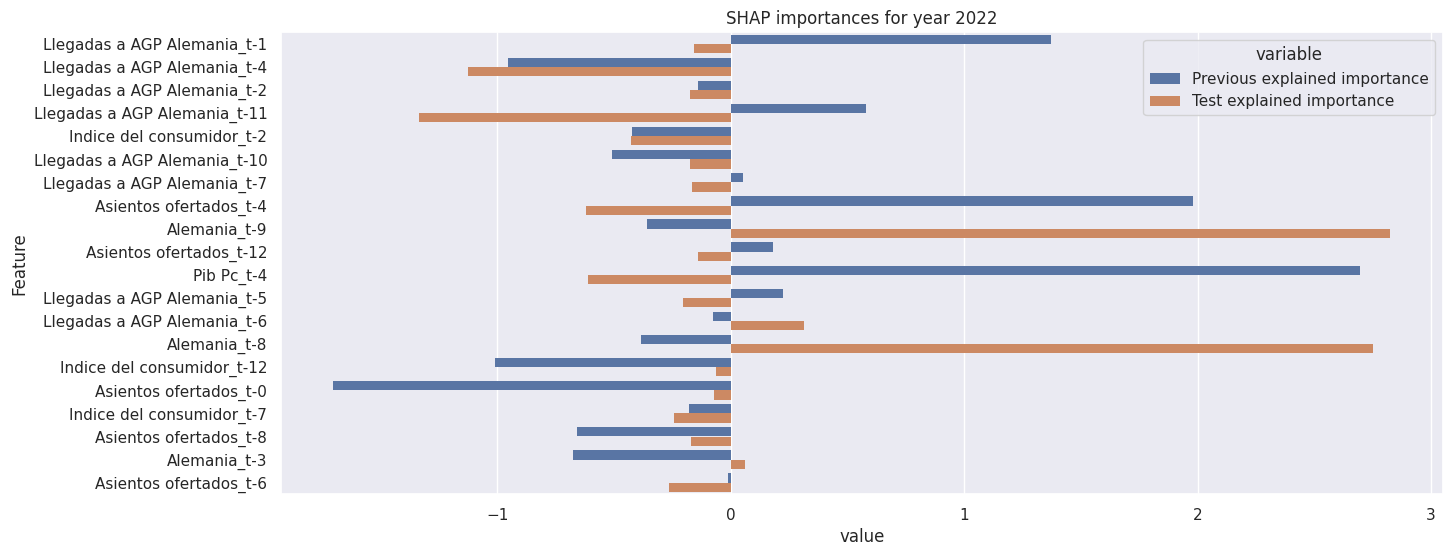

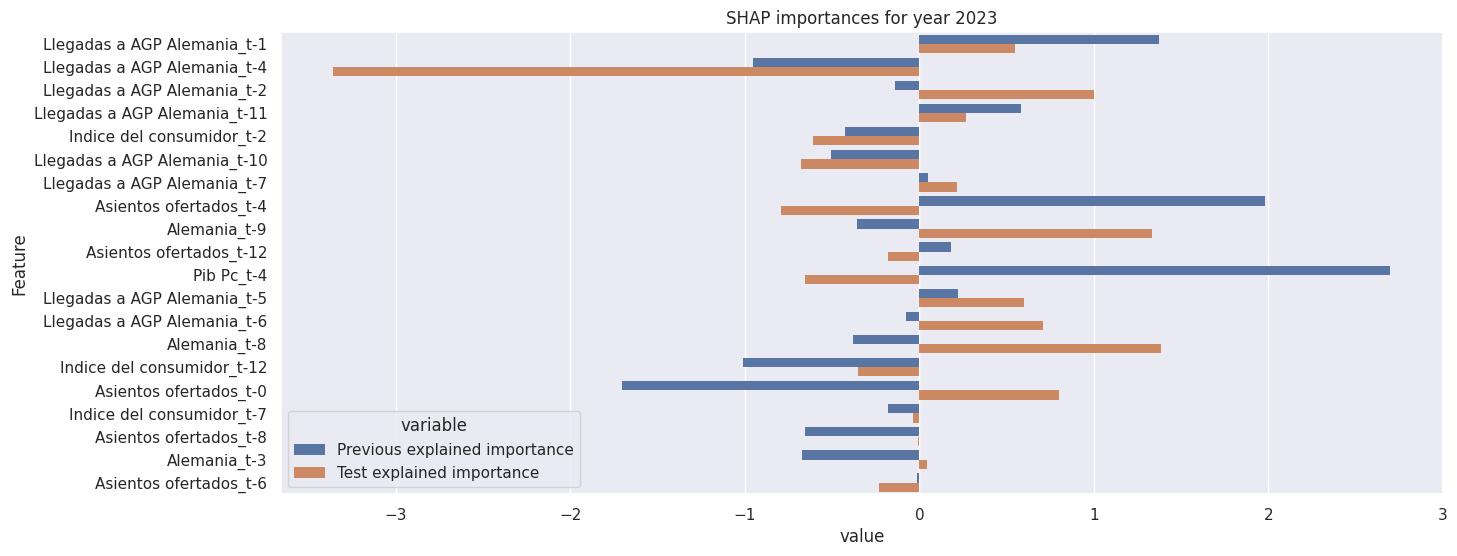

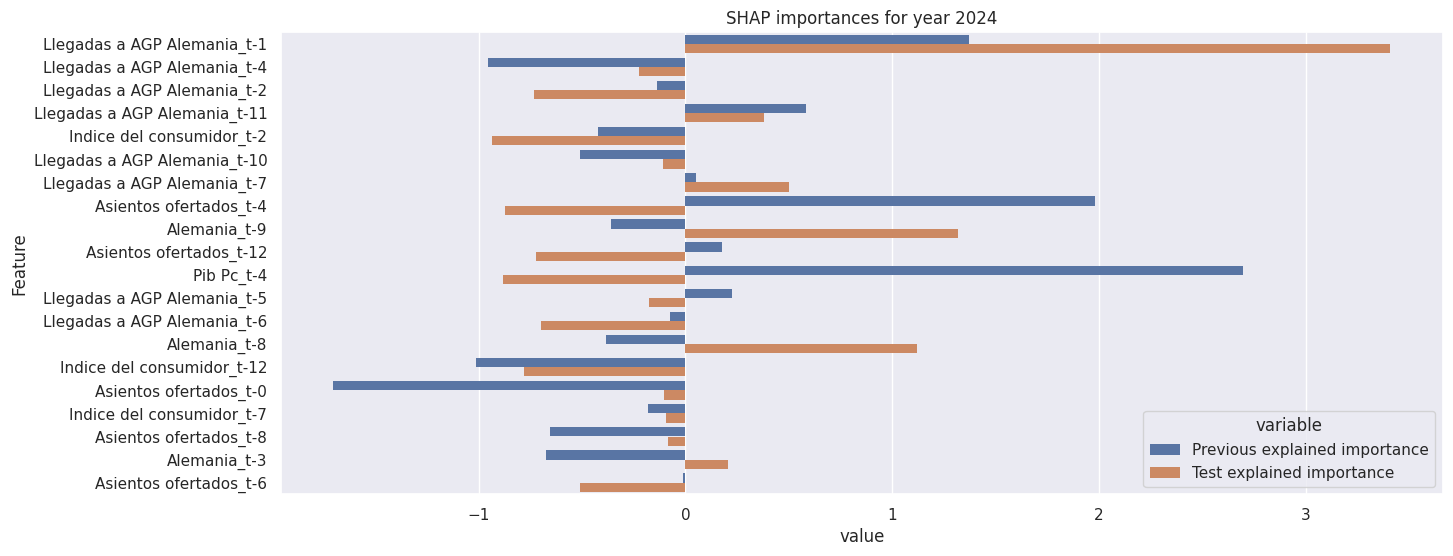

In [96]:
for year in years:
    fig, ax = plt.subplots(1, 1, figsize=(15, 6))
    year_data = xais_df[xais_df['Year'] == year].drop(columns=['Year', 'Distance'])
    tidy = year_data.melt(id_vars='Feature')
    sns.barplot(y=tidy['Feature'], x=tidy['value'], hue=tidy['variable'], ax=ax, linewidth=0)
    ax.set_title(f'SHAP importances for year {year}')

    # sns.barplot(y=year_data['Feature'], x=year_data['Test explained importance'], ax=ax)
    # sns.barplot(y=year_data['Feature'], x=year_data['Previous explained importance'], ax=ax)

#### Permutation importance

In [ ]:
# k=20
# idx = feature_importance_perm.index[:k].to_list()
# train_perm = timeseries_train.copy()[idx]
# idx.append(new_target_column)
# test_val_perm = timeseries_rest.copy()[idx]
# total_perm = timeseries_df.copy()[idx]
# model = XGBRegressor(**params)

# model, exp, preds, measures, xais = prediction(
#     ai=model,
#     train_data=train_perm,
#     train_target=y_train,
#     test_val_data=test_val_perm,
#     total_data=total_perm,
#     target_col=new_target_column
# )

In [ ]:
# new_measures = measures.copy()
# new_measures.pop(list(measures.keys())[0])

# drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

# print(drift)

#### Mutual info

2012
{'R2': 0.7261762200856305, 'MAE': 21339.192708333332, 'RMSE': 24970.363753626287}


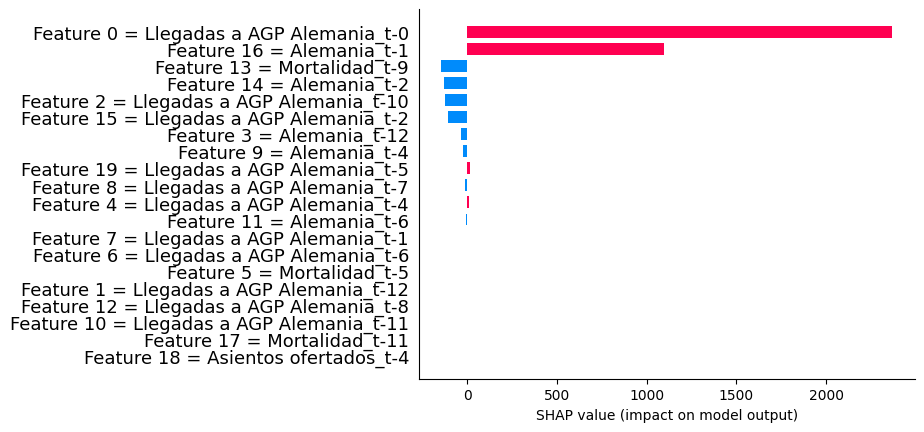

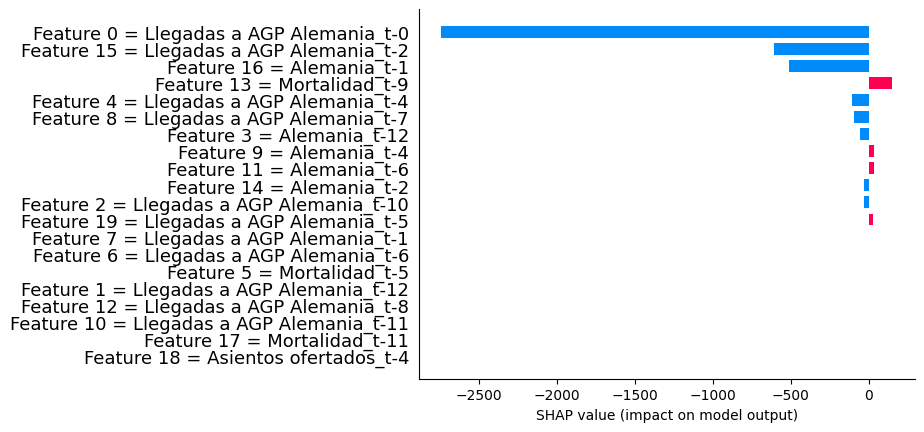

-----
2013
{'R2': 0.6872222977447977, 'MAE': 24926.685546875, 'RMSE': 30422.743079892756}


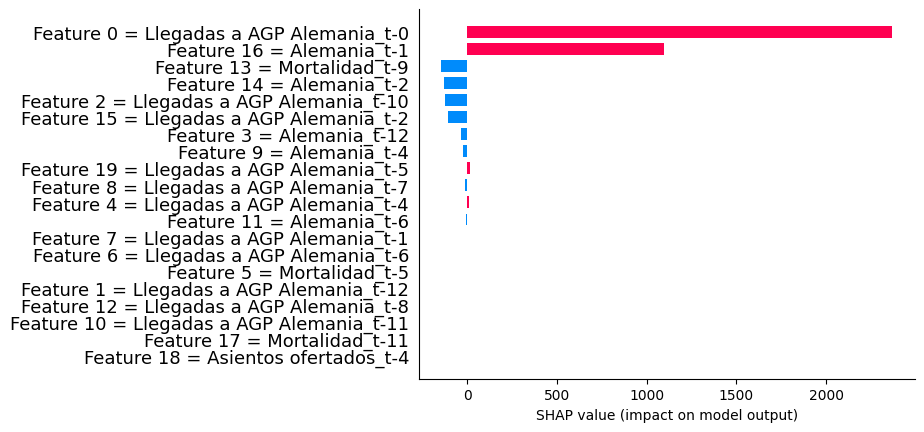

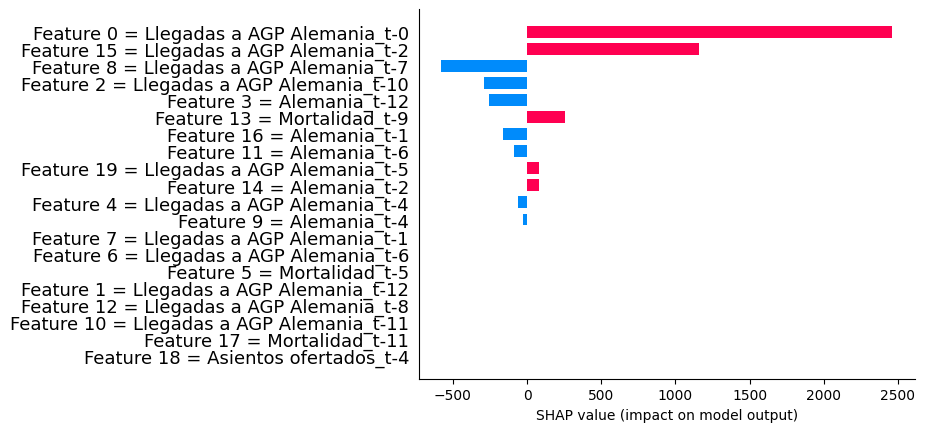

-----
2014
{'R2': 0.5845664731975716, 'MAE': 29073.100260416668, 'RMSE': 35414.64041621206}


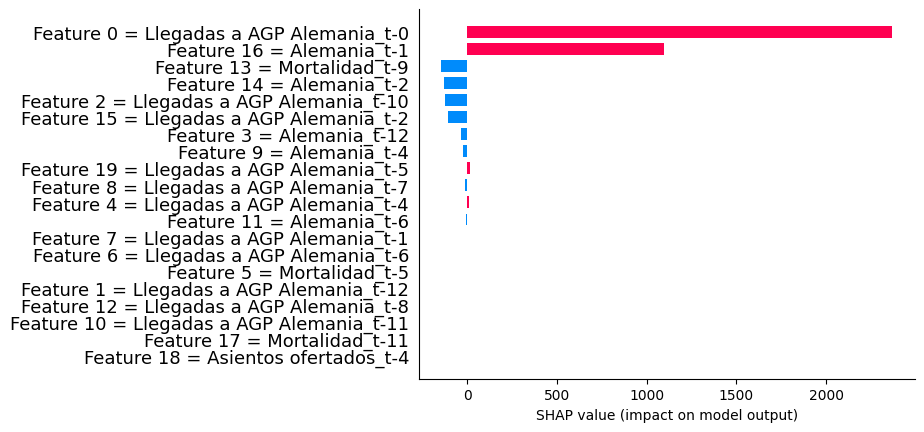

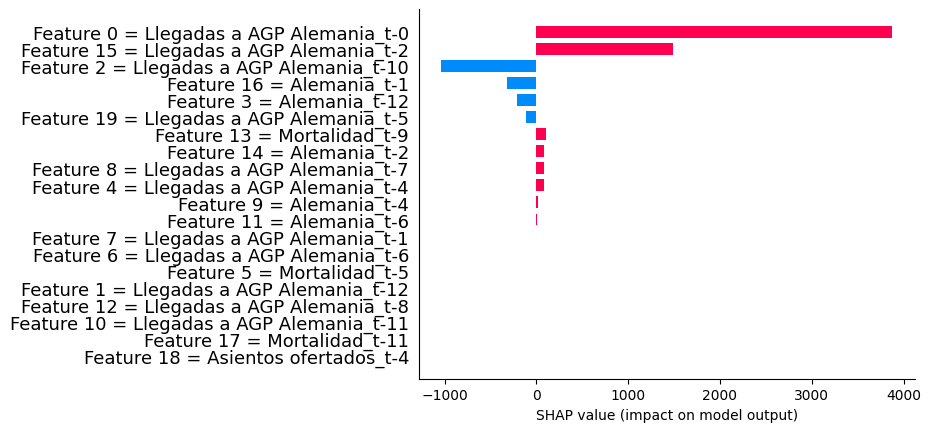

-----
2015
{'R2': 0.5102313543299251, 'MAE': 31522.505208333332, 'RMSE': 35204.06481650009}


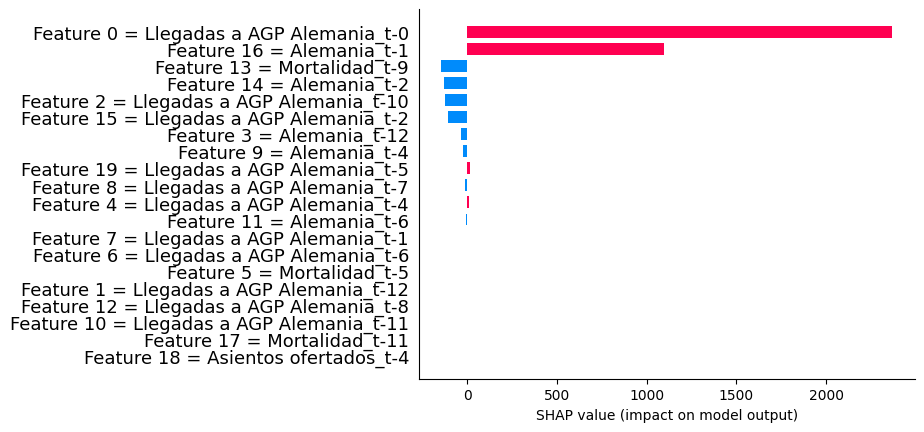

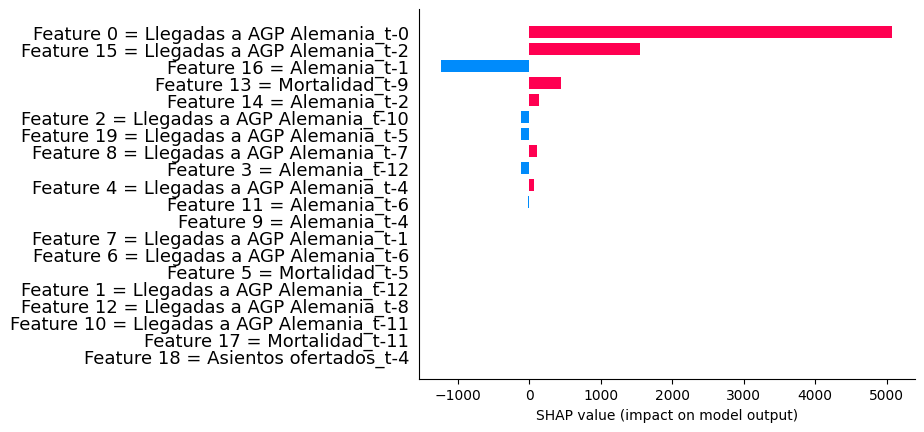

-----
2016
{'R2': 0.5132211578670315, 'MAE': 31991.940755208332, 'RMSE': 37125.060726710326}


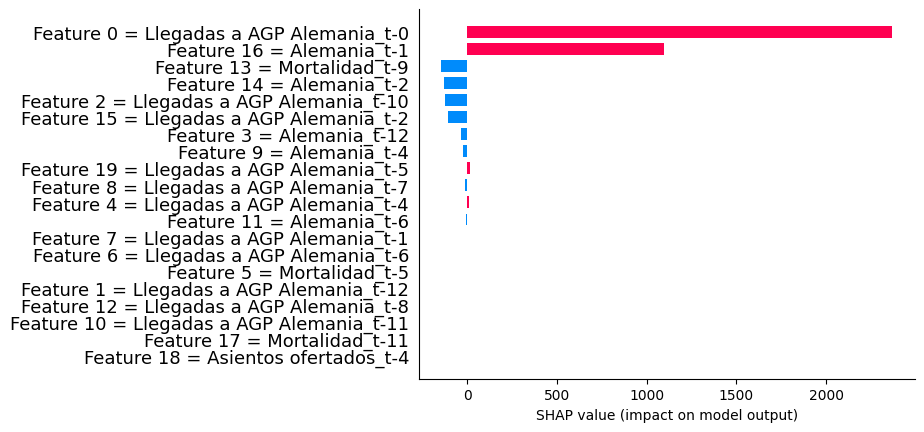

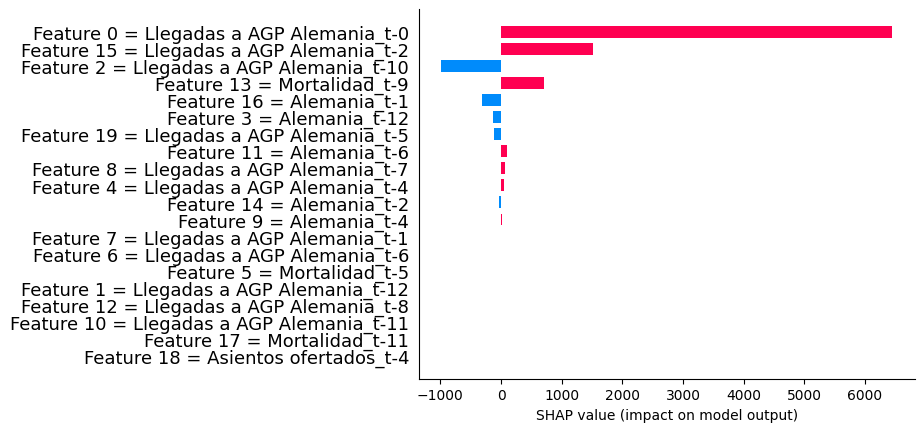

-----
2017
{'R2': 0.3815597506137349, 'MAE': 36975.963541666664, 'RMSE': 45617.05860599032}


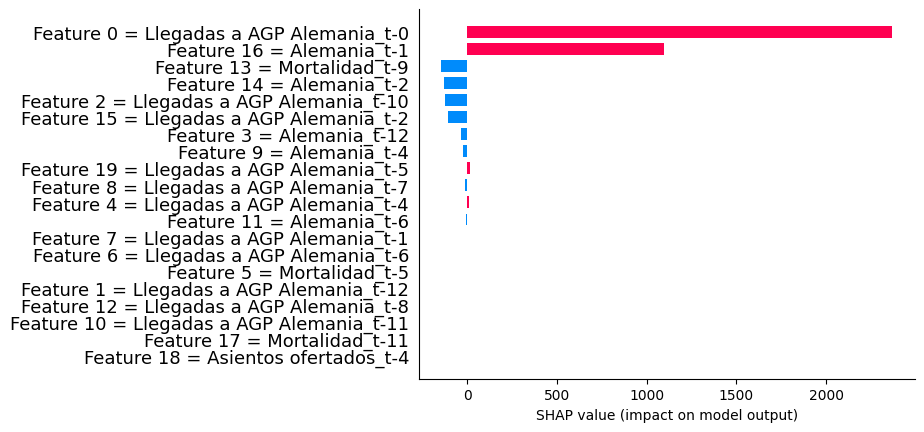

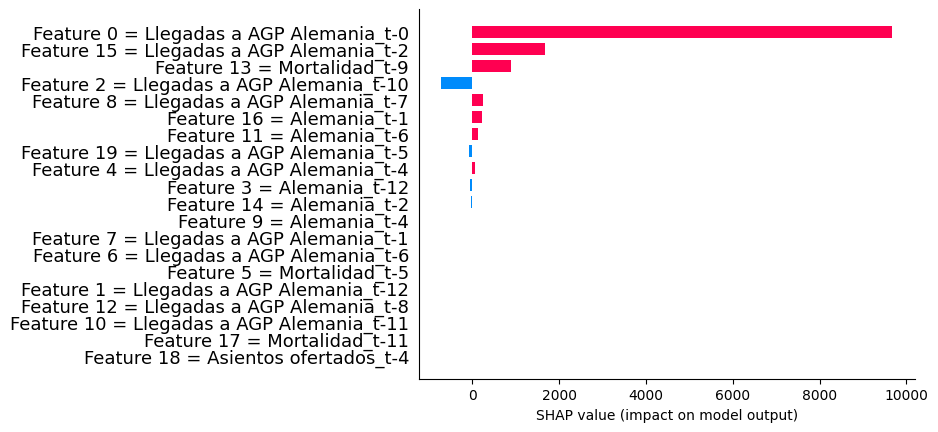

-----
2018
{'R2': 0.17744968074360334, 'MAE': 38327.861328125, 'RMSE': 46045.03020183379}


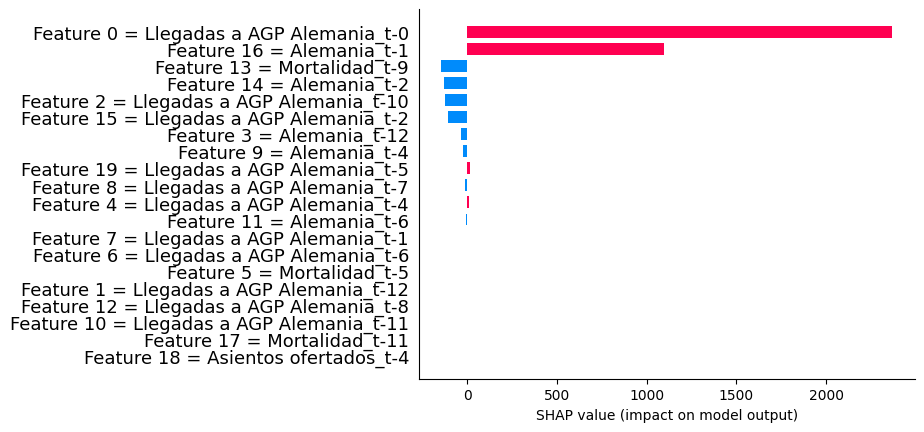

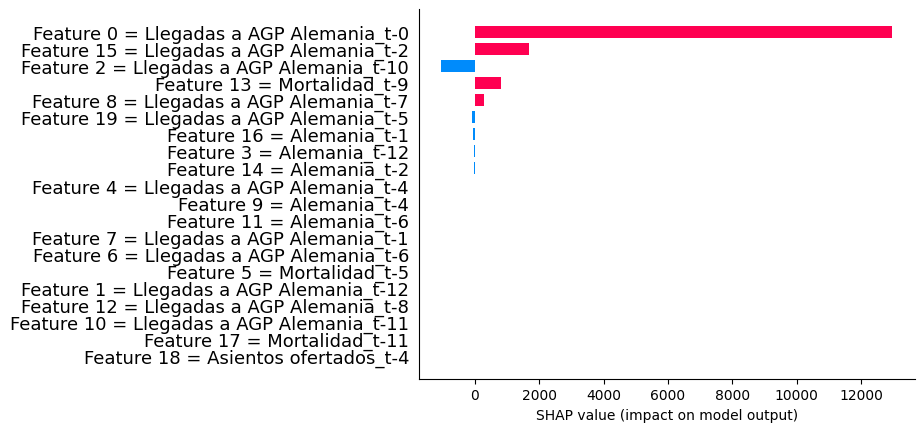

-----
2019
{'R2': -0.28673663779953507, 'MAE': 34625.381510416664, 'RMSE': 46375.9142338183}


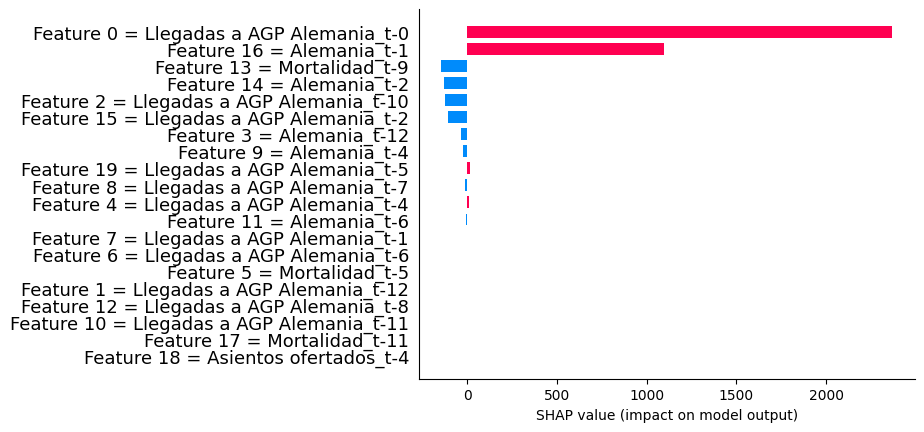

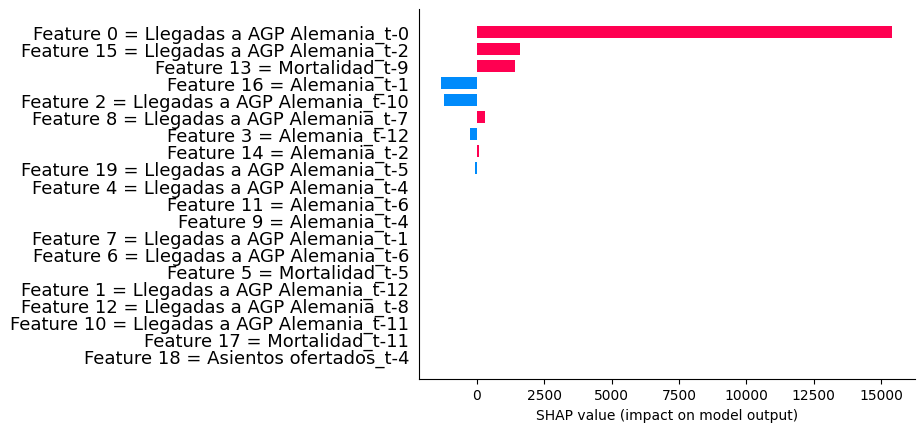

-----
2020
{'R2': -8.17333245541068, 'MAE': 83844.744140625, 'RMSE': 86519.92218671316}


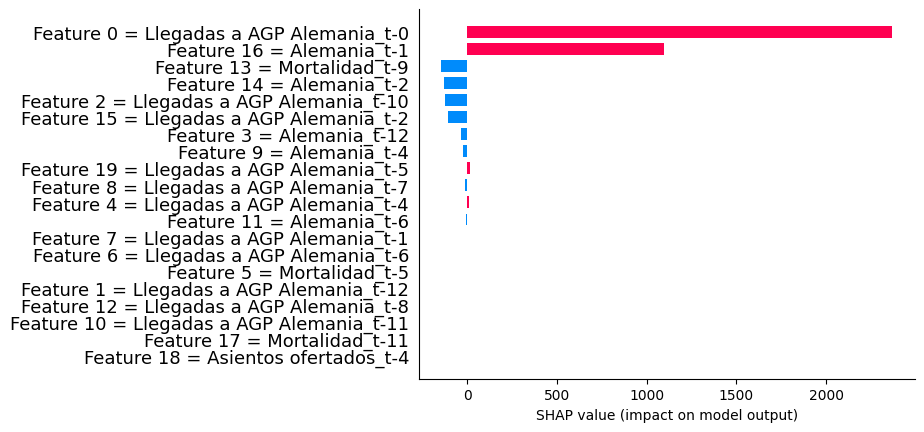

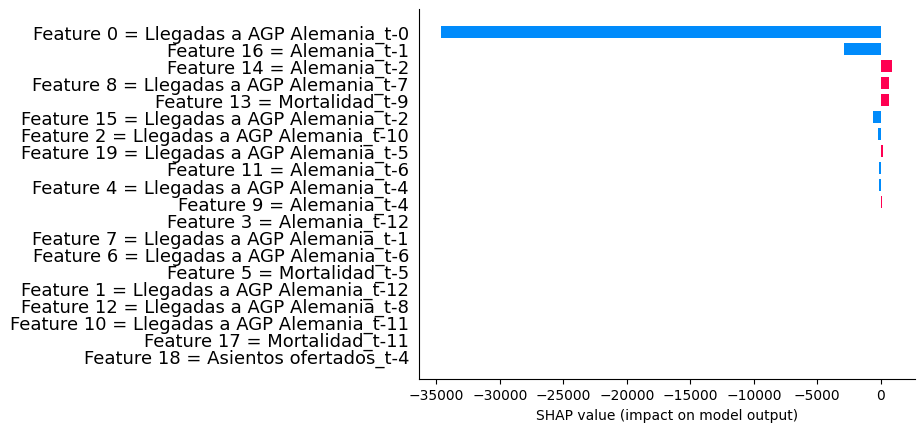

-----
2021
{'R2': -3.5711780900836434, 'MAE': 80464.900390625, 'RMSE': 83264.03686156866}


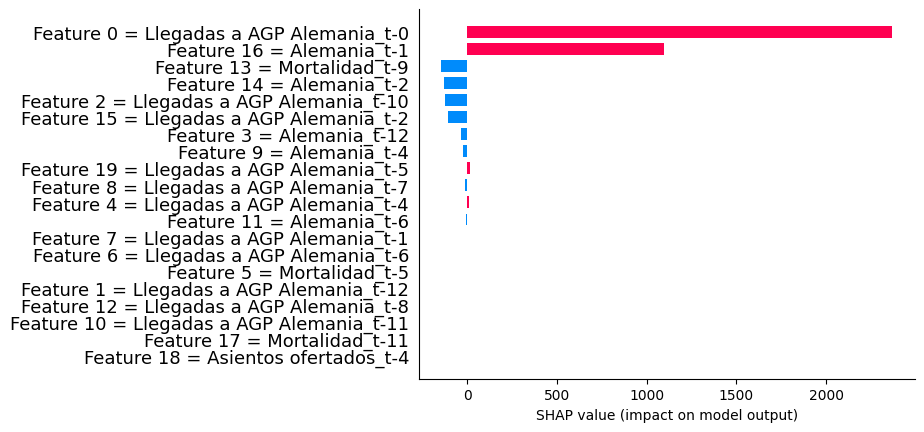

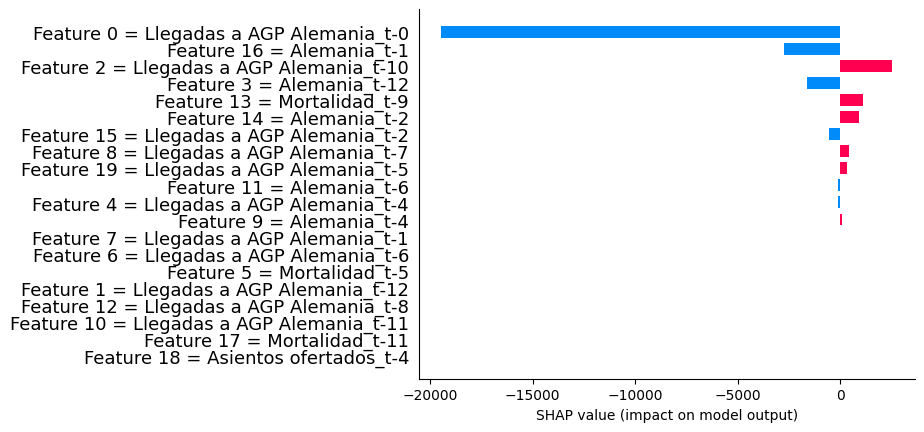

-----
2022
{'R2': -1.5762708240731262, 'MAE': 53198.463541666664, 'RMSE': 56410.22671482417}


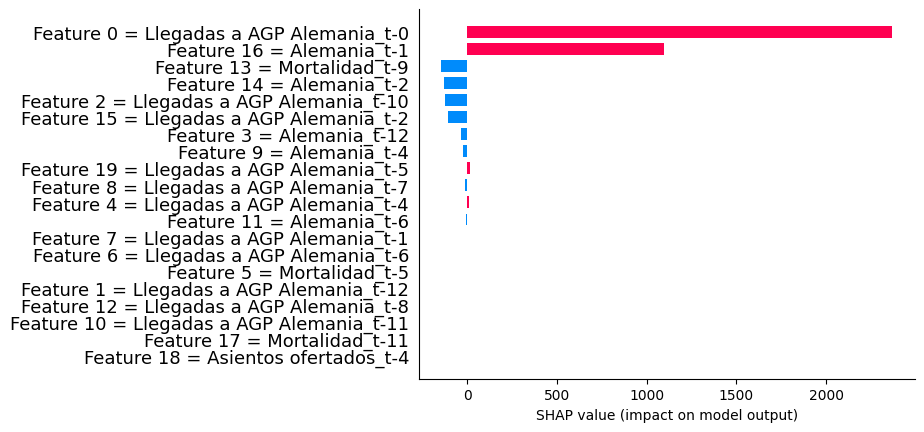

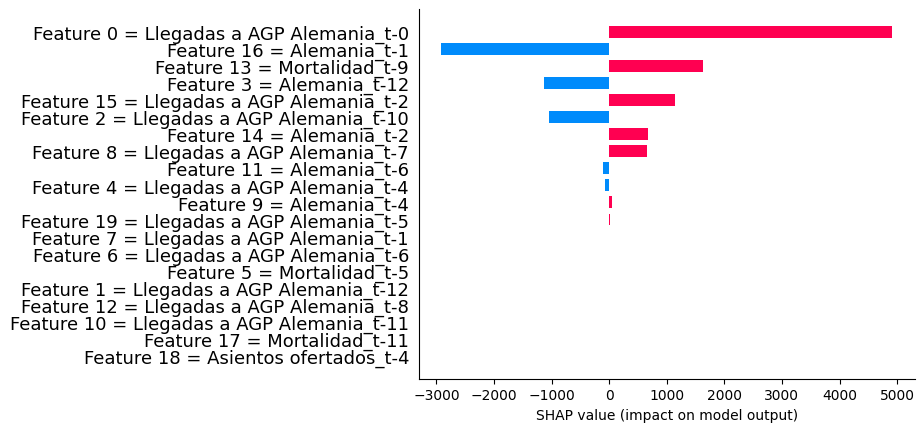

-----
2023
{'R2': -0.5718197802578646, 'MAE': 37535.794270833336, 'RMSE': 55151.25177244628}


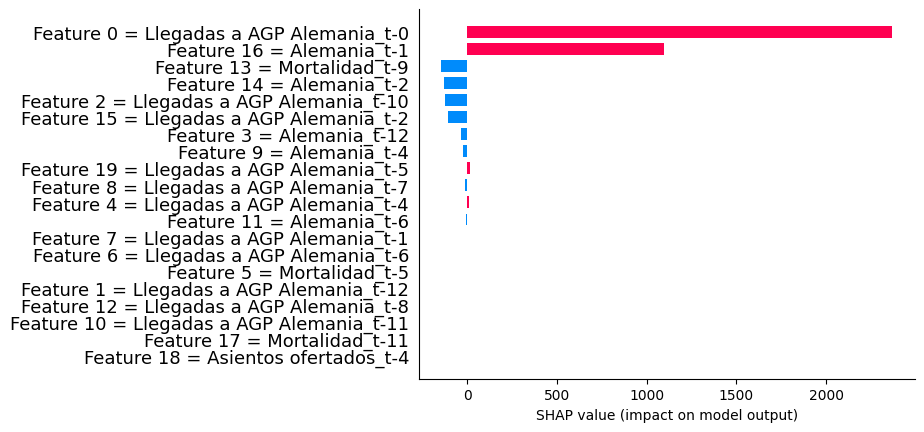

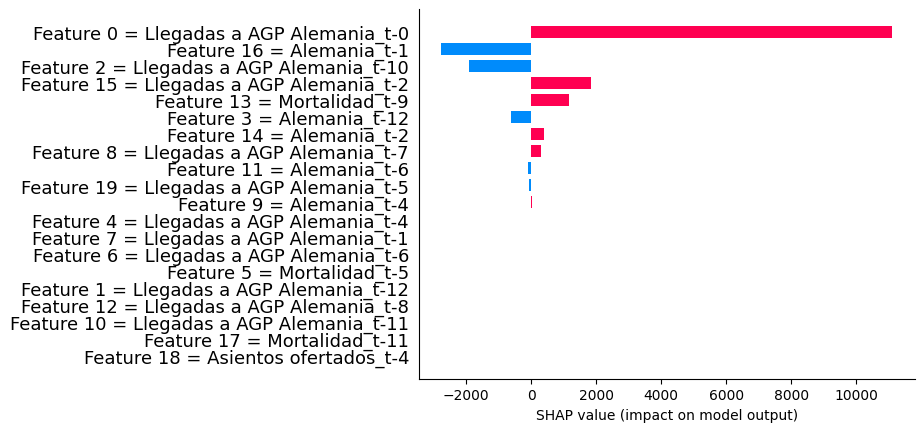

-----
2024
{'R2': 0.0, 'MAE': 152865.97526041666, 'RMSE': 152868.93772531665}


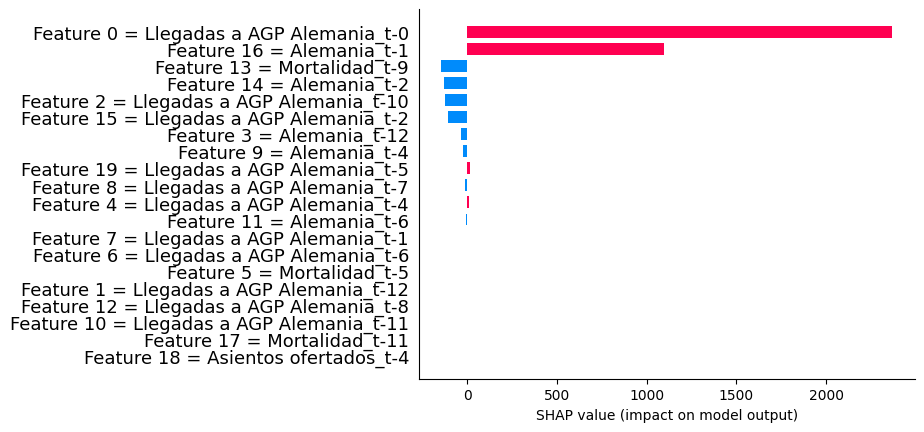

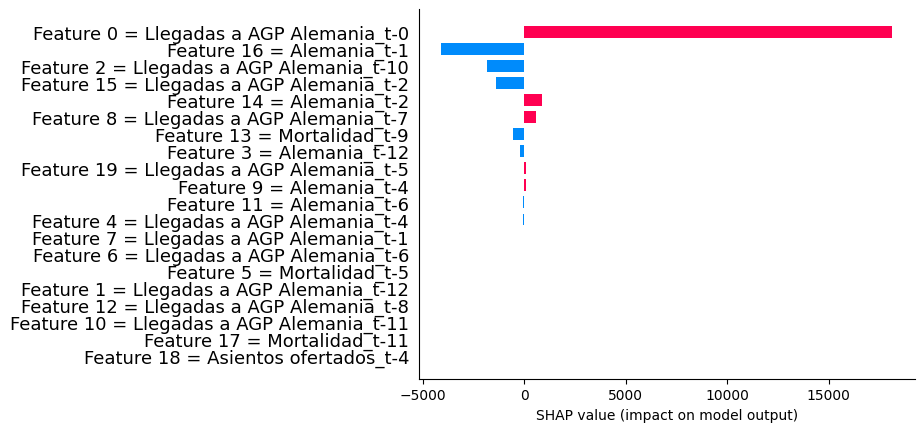

-----


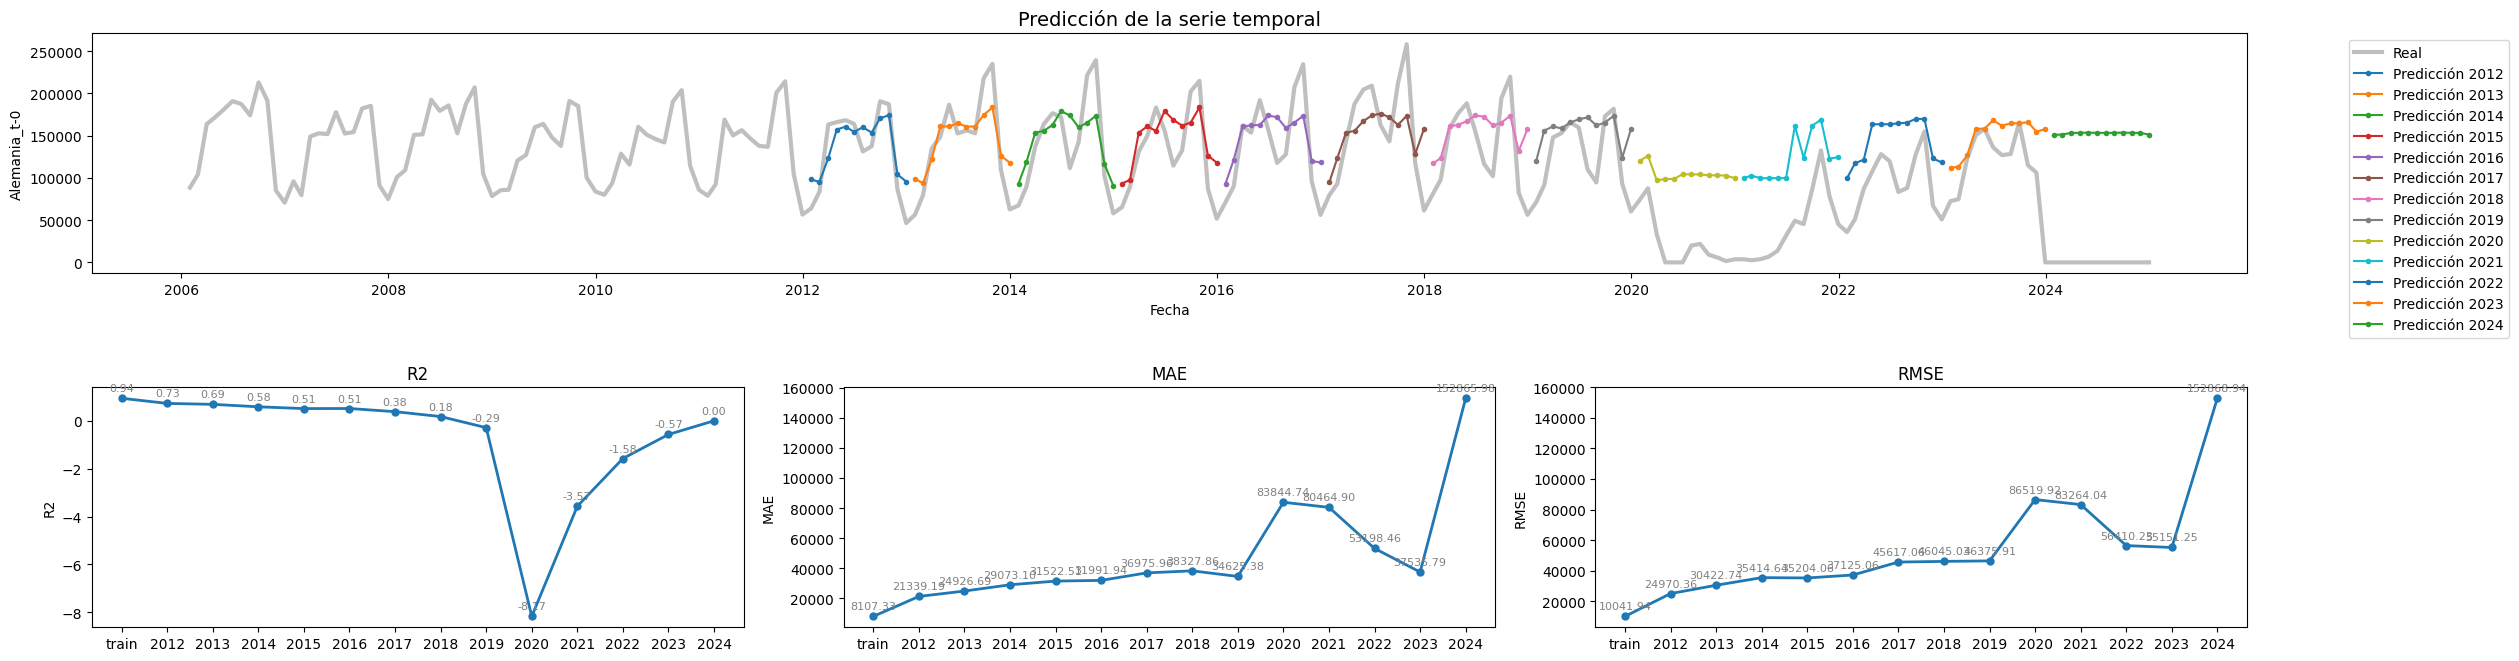

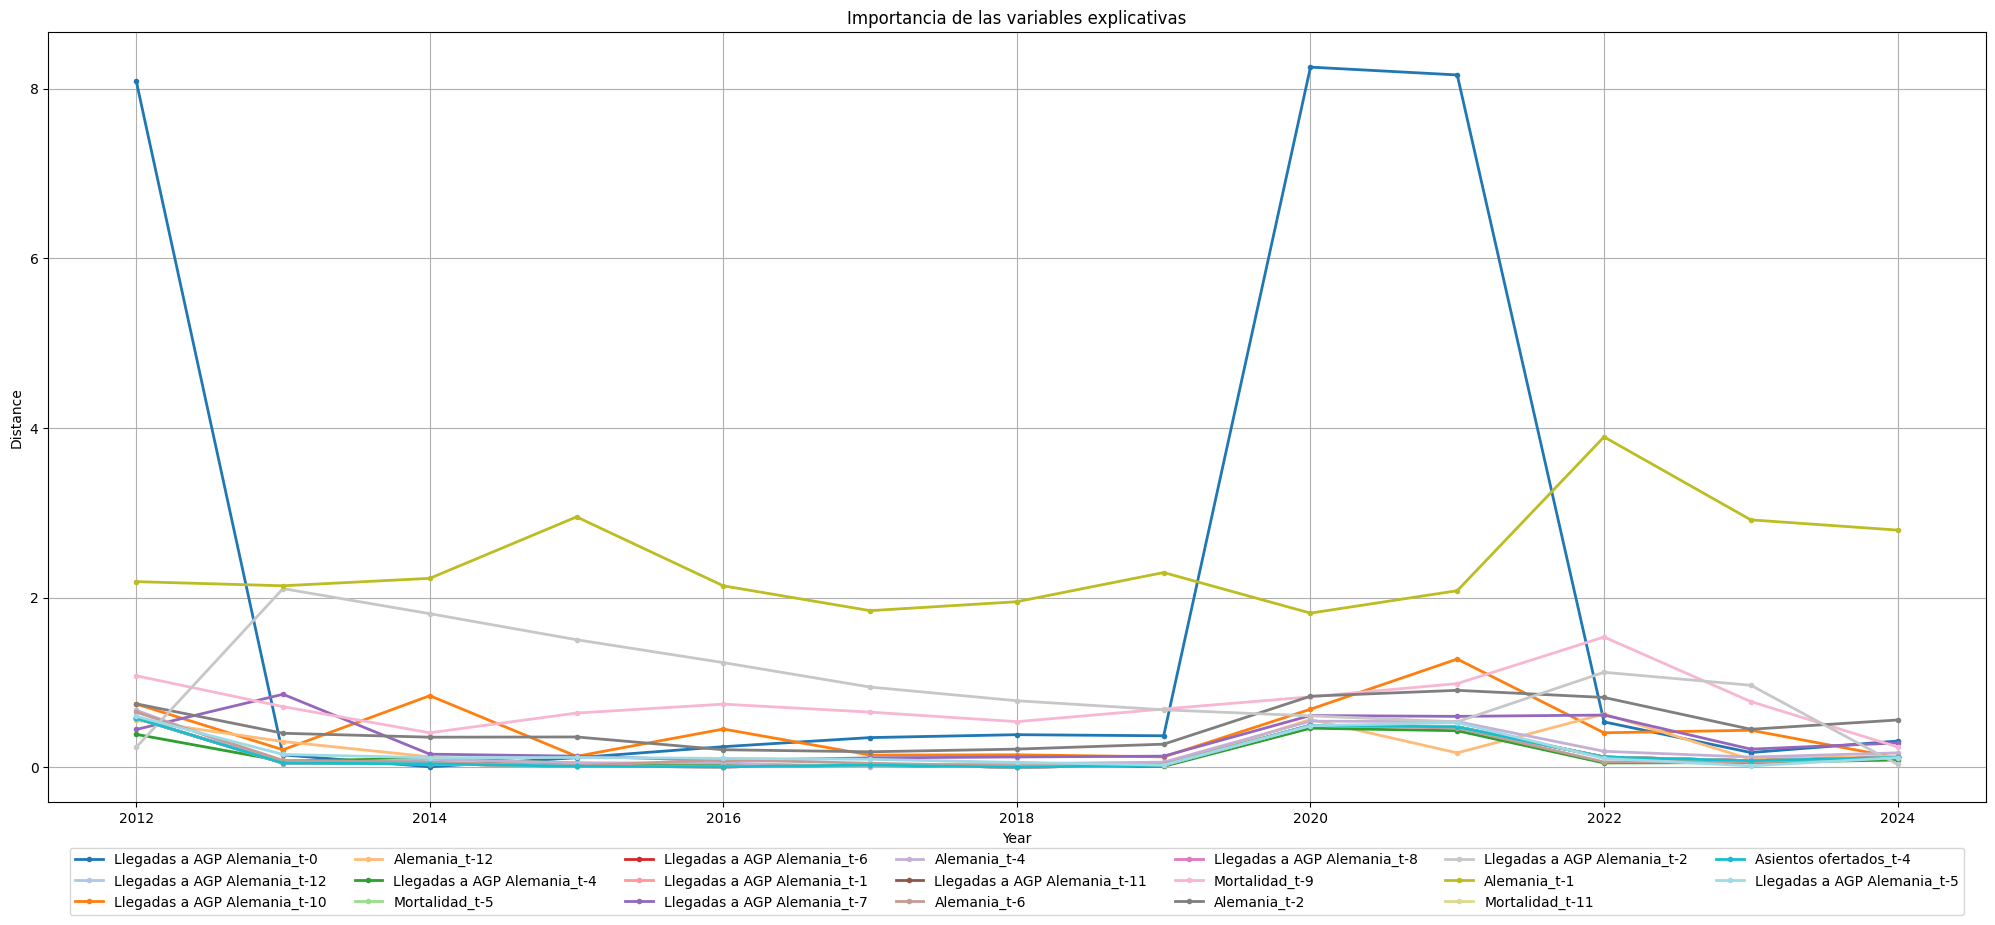

In [ ]:
# k=20
# idx = feature_importance_mi.index[:k].to_list()
# train_mi = timeseries_train.copy()[idx]
# idx.append(new_target_column)
# test_val_mi = timeseries_rest.copy()[idx]
# total_mi = timeseries_df.copy()[idx]
# model = XGBRegressor(**params)

# model, exp, preds, measures, xais = prediction(
#     ai=model,
#     train_data=train_mi,
#     train_target=y_train,
#     test_val_data=test_val_mi,
#     total_data=total_mi,
#     target_col=new_target_column
# )

In [ ]:
new_measures = measures.copy()
new_measures.pop(list(measures.keys())[0])

drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

print(drift)

#### Correlation matrix

In [ ]:
# k=20
# idx = feature_importance_corr.index[:k].to_list()
# train_corr = timeseries_train.copy()[idx]
# idx.append(new_target_column)
# test_val_corr = timeseries_rest.copy()[idx]
# total_corr = timeseries_df.copy()[idx]
# model = XGBRegressor(**params)

# model, exp, preds, measures, xais = prediction(
#     ai=model,
#     train_data=train_corr,
#     train_target=y_train,
#     test_val_data=test_val_corr,
#     total_data=total_corr,
#     target_col=new_target_column
# )

In [ ]:
# new_measures = measures.copy()
# new_measures.pop(list(measures.keys())[0])

# drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

# print(drift)

#### Tree feature importance

In [ ]:
# k=20
# idx = rf_feats.index[:k].to_list()
# train_corr = timeseries_train.copy()[idx]
# idx.append(new_target_column)
# test_val_corr = timeseries_rest.copy()[idx]
# total_corr = timeseries_df.copy()[idx]
# model = XGBRegressor(**params)

# model, exp, preds, measures, xais = prediction(
#     ai=model,
#     train_data=train_corr,
#     train_target=y_train,
#     test_val_data=test_val_corr,
#     total_data=total_corr,
#     target_col=new_target_column
# )

In [ ]:
# new_measures = measures.copy()
# new_measures.pop(list(measures.keys())[0])

# drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

# print(drift)

## Anlysis by month

In [ ]:
def prediction_by_month(
        ai,
        train_data,
        train_target,
        test_val_data,
        total_data,
        target_col
):
    ai.fit(train_data, train_target)
    # explainer = shap.Explainer(ai, masker=shap.maskers.Independent(data=train_data))
    explainer = shap.TreeExplainer(ai, train_data)
    train_shap = explainer.shap_values(train_data.head(24))

    preds = {}
    xais = {}
    measures = {
        'train': {
            'R2': r2_score(train_target, ai.predict(train_data)),
            'MAE': mean_absolute_error(train_target, ai.predict(train_data)),
            'RMSE': root_mean_squared_error(train_target, ai.predict(train_data))
        }
    }

    for year in test_val_data.index.year.unique():
        print(year)
        test_year = test_val_data[test_val_data.index.year == year]
        for month in test_year.index.month.unique():
            print(month)

            test_month = test_year[test_year.index.month == month]

            X_test = test_month.drop(columns=[target_col])
            y_test = test_month[target_col]

            preds[f'{year}-{month}'], measures[f'{year}-{month}'], xais[f'{year}-{month}'] = time_series_predict(
                model=ai,
                prev_shap_values=train_shap,
                data=X_test,
                target=y_test,
                explainer=explainer
            )

        # X_test = test_year.drop(columns=['Suecia_t-0'])
        # y_test = test_year['Suecia_t-0']

        # preds[year], measures[year], xais[year] = time_series_predict(
        #     model=ai,
        #     prev_shap_values=train_shap,
        #     data=X_test,
        #     target=y_test,
        #     explainer=explainer
        # )
        # print("-----")

    return model, explainer, preds, measures, xais

In [ ]:
# k=20
# idx = feature_importance_mi.index[:k].to_list()
# train_mi = timeseries_train.copy()[idx]
# idx.append('Suecia_t-0')
# test_val_mi = timeseries_rest.copy()[idx]
# total_mi = timeseries_df.copy()[idx]
model = XGBRegressor(**params)

model, exp, preds, measures, xais = prediction_by_month(
    ai=model,
    train_data=train_mi,
    train_target=y_train,
    test_val_data=test_val_mi,
    total_data=total_mi,
    target_col=new_target_column
)

In [ ]:
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)

sns.lineplot(x=timeseries_df.index, y=timeseries_df[new_target_column], label='Real', linewidth=3, alpha=0.5, color='gray', ax=ax1)
sns.lineplot(x=pd.to_datetime(list(preds.keys())), y=np.ndarray.flatten(np.array(list(preds.values()))), label='Predicción', marker='o', markeredgewidth=0, markersize=4, ax=ax1)
ax1.set_title('Predicción de la serie temporal', fontsize=14)


ax2_1 = plt.subplot2grid((2, 3), (1, 0))
ax2_2 = plt.subplot2grid((2, 3), (1, 1))
ax2_3 = plt.subplot2grid((2, 3), (1, 2))

measures_df = pd.DataFrame(measures).T

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_1 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[0]]):
    ax2_1.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_1.set_title(measures_df.columns[0])
ax2_1.xaxis.set_tick_params(rotation=90)

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_2 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[1]]):
    ax2_2.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_2.set_title(measures_df.columns[1])
ax2_2.xaxis.set_tick_params(rotation=90)

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_3 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[2]]):
    ax2_3.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_3.set_title(measures_df.columns[2])
ax2_3.xaxis.set_tick_params(rotation=90)


fig.show()

In [ ]:
new_measures = measures.copy()
new_measures.pop(list(measures.keys())[0])

drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

print(drift)

## Analysis by trimester

In [ ]:
def prediction_by_quarter(
        ai,
        train_data,
        train_target,
        test_val_data,
        total_data,
        target_col
):
    ai.fit(train_data, train_target)
    # explainer = shap.Explainer(ai, masker=shap.maskers.Independent(data=train_data))
    explainer = shap.TreeExplainer(ai, train_data)
    train_shap = explainer.shap_values(train_data.head(24))

    preds = {}
    xais = {}
    measures = {
        'train': {
            'R2': r2_score(train_target, ai.predict(train_data)),
            'MAE': mean_absolute_error(train_target, ai.predict(train_data)),
            'RMSE': root_mean_squared_error(train_target, ai.predict(train_data))
        }
    }

    for year in test_val_data.index.year.unique():
        print(year)
        test_year = test_val_data[test_val_data.index.year == year]
        for quarter in range(1, 5):
            print(f'Q{quarter}')
            test_quarter = test_year[test_year.index.quarter == quarter]

            if not test_quarter.empty:
                X_test = test_quarter.drop(columns=[target_col])
                y_test = test_quarter[target_col]

                preds[f'{year}-Q{quarter}'], measures[f'{year}-Q{quarter}'], xais[f'{year}-Q{quarter}'] = time_series_predict(
                    model=ai,
                    prev_shap_values=train_shap,
                    data=X_test,
                    target=y_test,
                    explainer=explainer
                )

        print("-----")

    return model, explainer, preds, measures, xais

In [ ]:
model = XGBRegressor(**params)

model, exp, preds, measures, xais = prediction_by_quarter(
    ai=model,
    train_data=train_mi,
    train_target=y_train,
    test_val_data=test_val_mi,
    total_data=total_mi,
    target_col=new_target_column
)

In [ ]:
fig = plt.figure(figsize=(20, 12))
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=3)

sns.lineplot(x=timeseries_df.index, y=timeseries_df[new_target_column], label='Real', linewidth=3, alpha=0.5, color='gray', ax=ax1)
sns.lineplot(x=timeseries_df[timeseries_df.index.year > 2011].index, y=np.ndarray.flatten(np.array(list(preds.values()))), label='Predicción', marker='o', markeredgewidth=0, markersize=4, ax=ax1)
ax1.set_title('Predicción de la serie temporal', fontsize=14)

ax2_1 = plt.subplot2grid((2, 3), (1, 0))
ax2_2 = plt.subplot2grid((2, 3), (1, 1))
ax2_3 = plt.subplot2grid((2, 3), (1, 2))

measures_df = pd.DataFrame(measures).T

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[0]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_1 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[0]]):
    ax2_1.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_1.set_title(measures_df.columns[0])
ax2_1.xaxis.set_tick_params(rotation=90)

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[1]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_2 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[1]]):
    ax2_2.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_2.set_title(measures_df.columns[1])
ax2_2.xaxis.set_tick_params(rotation=90)

sns.lineplot(x=measures_df.index.to_list(), y=measures_df[measures_df.columns[2]], marker='o', markeredgewidth=0, markersize=6, ax=ax2_3 , linewidth=2)
for i, txt in enumerate(measures_df[measures_df.columns[2]]):
    ax2_3.annotate(f'{txt:.2f}', (measures_df.index.to_list()[i], txt), textcoords="offset points", xytext=(0,5), ha='center', fontsize=8, color='gray')
ax2_3.set_title(measures_df.columns[2])
ax2_3.xaxis.set_tick_params(rotation=90)


fig.show()

In [ ]:
new_measures = measures.copy()
new_measures.pop(list(measures.keys())[0])

drift, measures_variance = calculate_measures_drift(new_measures, measures['train'], threshold)

print(drift)